# Fit bambi model to males and females combined

In [1]:
import jax
import joblib
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from tqdm.auto import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PlotConfig,
    save_factory,
    COLORMAPS,
)
from copy import deepcopy
from operator import or_
from toolz import reduce, valmap, keyfilter, pluck
from aging.behavior.bio_age_model import (
    fit_model,
    masked_xval,
    raise_dim
)
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA, NMF
from scipy.stats import ks_2samp
from itertools import product
from scipy.stats import norm
from itertools import combinations

In [2]:
# only for groups folder migration
from pathlib import Path
c = PlotConfig(save_path=Path('/n/scratch/users/w/wg41/figures/aging'))

In [3]:
format_plots()
# c = PlotConfig()
saver = save_factory(c.save_path / "fig4", tight_layout=False)

In [4]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_


def minmax(df):
    return (df - df.min()) / (df.max() - df.min())

In [5]:
def make_plot(age_df, width, height):
    boundaries = np.arange(age_df["labels"].max() + 2) - 0.5
    pal = sns.blend_palette([COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)], as_cmap=True)
    fig = figure(width, height)
    ax = sns.lineplot(
        data=age_df,
        x="true_ages",
        y="bio_ages",
        hue="labels",
        palette=[COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)],
        legend=False,
        zorder=-1,
        lw=0.25,
        err_kws=dict(lw=0),
    )
    perm = np.random.permutation(len(age_df))
    im = ax.scatter(
        age_df["true_ages"].iloc[perm],
        age_df["bio_ages"].iloc[perm],
        c=age_df["labels"].iloc[perm],
        cmap=pal,
        vmin=0,
        vmax=1,
        s=1,
    )
    cb = fig.colorbar(
        mappable=im,
        boundaries=boundaries,
        ax=ax,
        label="Sex",
    )
    cb.set_ticks(range(0, 2))
    cb.set_ticklabels(["Male", "Female"])
    add_identity(ax, c="k", ls="--", zorder=-2)
    ax.set(
        xlabel="Chronological age (weeks)",
        ylabel="Behavioral age (weeks)",
        aspect="equal",
        xlim=(0, 120),
    )
    sns.despine()
    return fig

In [6]:
def read_male_ontogeny(use_syllables):
    df = pd.read_parquet(
        # "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_counts_matrix_v00.parquet"
        "/n/scratch/users/w/wg41/ontogeny_data/version_11-1/ontogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    # pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_mouse_area_df_v00.parquet'
    pth = '/n/scratch/users/w/wg41/ontogeny_data/version_11-1/ontogeny_males_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]
    df = df[use_syllables]
    return df, sizes_col


def read_female_ontogeny(use_syllables):
    df = pd.read_parquet(
        # "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_counts_matrix_v00.parquet"
        "/n/scratch/users/w/wg41/ontogeny_data/version_11-1/ontogeny_females_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    # re-assign 52-wk old animals from their incorrect 8-wk old assignment
    x = ['d6f254af-d55a-427a-96e0-c452a233cbe2', '242bee8e-0ee7-45e7-8a13-678836a4cddb']

    idx = df.index.names
    tmp_df = df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    df = tmp_df.set_index(idx)

    # pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_mouse_area_df_v00.parquet'
    pth = '/n/scratch/users/w/wg41/ontogeny_data/version_11-1/ontogeny_females_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    idx = size_df.index.names
    tmp_df = size_df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    size_df = tmp_df.set_index(idx)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]

    df = df[use_syllables]

    age_mapping = {
        93: 94,
        95: 94,
        97: 98,
        98: 98,
        102: 98,
        103: 105,
        105: 105,
        107: 105
    }

    df = df.reset_index(level='age')
    df['age'] = df['age'].map(age_mapping).fillna(df['age'])

    return df.set_index('age', append=True).reorder_levels(idx), sizes_col

In [7]:
# keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
keep_syllables = np.loadtxt('/n/scratch/users/w/wg41/ontogeny_data/version_11/to_keep_syllables_raw.txt', dtype=int)

In [8]:
df, sizes_col = read_male_ontogeny(keep_syllables)
female_df, female_sizes_col = read_female_ontogeny(keep_syllables)
df = pd.concat([df, female_df])

age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))

label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
sex_id = label_encoder.fit_transform(
    np.hstack([np.zeros(len(df) - len(female_df)), np.ones(len(female_df))])[:, None]
).T

sort_idx = np.argsort(syllable_counts_jax.mean(0))[::-1]

df['sex'] = np.where(sex_id == 1)[0]
df = df.set_index('sex', append=True)

In [9]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": pd.concat([sizes_col, female_sizes_col]).to_numpy(),  # models > 1
    "mice": sex_id,
}

age_sd = 0.04

hypparams = {
    "log_age": True,
    "min_age": 3,
    "max_age": 130,
    "age_sd": age_sd,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "scale": 400,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(sex_id),
    "lr": 0.25,
    "n_opt_iter": 600,
}

## Get males vs females

In [10]:
mdl = fit_model(features, hypparams, 5, return_loss_on_error=True)

if len(mdl) == 1:
    print(hypparams['n_opt_iter'] - np.isnan(mdl['loss']).sum())

# Plots and analysis

In [11]:
labels = LabelEncoder().fit_transform(np.hstack([np.zeros(len(df) - len(female_df)), np.ones(len(female_df))]))

## Predicted syllables plot

In [ ]:
# male is blue, female is orange
example_mice = [0, 1]

mask = []
for m in example_mice:
    mask.append(labels == m)
mask = reduce(or_, mask)

sylls = [0, 1, 3, 5, 6, 8, 10, 14, 15, 19, 23]
fig, ax = plt.subplots(len(sylls), 3, figsize=(3, len(sylls)), sharex=True, dpi=900)

true_age = mdl["true_ages"][mask]
bio_age = mdl["bio_ages"][mask]
counts = mdl["counts"][mask]
pred_counts = mdl["predicted_counts"][mask]

pal = sns.blend_palette([COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)], as_cmap=True)

for a, syll, i in zip(ax, map(lambda i: int(sort_idx[i]), sylls), sylls):
    max_counts = max([counts[:, syll].max(), pred_counts[:, syll].max()]) * 1.05
    a[0].scatter(true_age, counts[:, syll], s=2.5, c=labels[mask], cmap=pal, vmax=1, vmin=0, rasterized=True)
    a[0].set(title=f"Idx {i} Syllable {df.columns[syll]}", ylabel="Counts", xlabel="Chron. age (weeks)", ylim=(0, max_counts))

    a[2].scatter(bio_age, pred_counts[:, syll], s=2.5, c=labels[mask], cmap=pal, vmax=1, vmin=0, rasterized=True)
    a[2].set(ylabel="Pred. counts", xlabel="Beh. age (weeks)", ylim=(0, max_counts), yticklabels=[])

    a[1].scatter(bio_age, counts[:, syll], s=2.5, c=labels[mask], cmap=pal, vmax=1, vmin=0, rasterized=True)
    a[1].set(ylabel="Counts", xlabel="Beh. age (weeks)", ylim=(0, max_counts), yticklabels=[])

sns.despine()
fig.tight_layout()

saver(fig, "sex-ontogeny-true-vs-predicted-counts", dpi=900);

In [13]:
list(mdl['params'])

['bio_basis_weights', 'development_weights', 'individual_biases', 'size_slope']

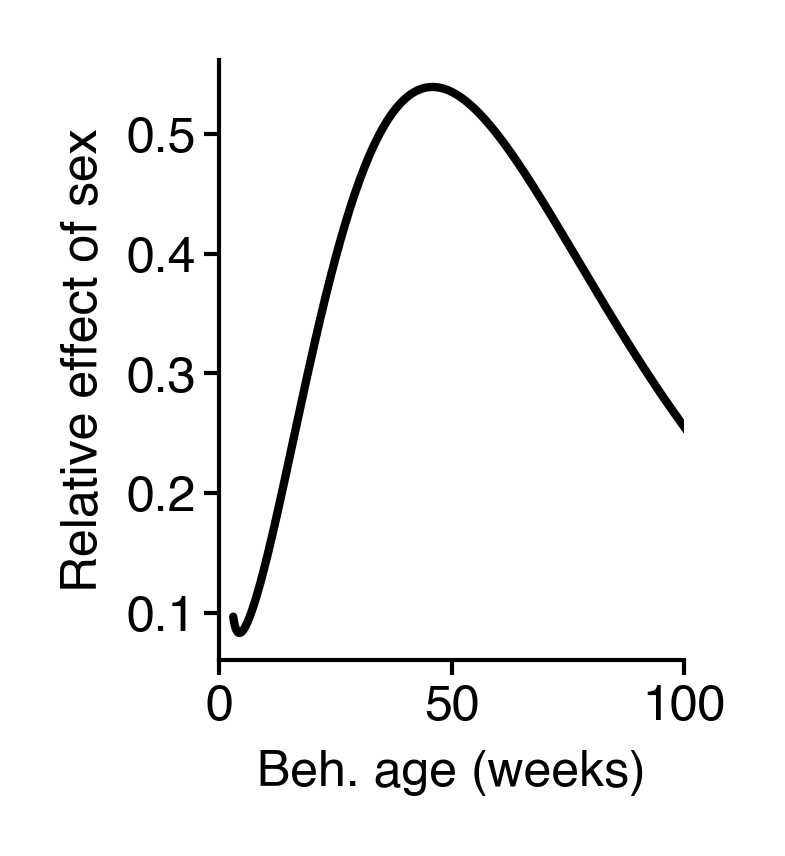

In [14]:
comps = mdl['init_components']

x = mdl['params']['development_weights']
dev = np.exp(x @ comps.bases['development']).squeeze()

fig = figure(1, 1.3)
ax = fig.gca()
ax.plot(comps.age_unnormalizer(comps.age_samples), dev, color='k')
plt.xlim(0, 100)
# plt.ylim(0, None)
plt.xlabel("Beh. age (weeks)")
plt.ylabel("Relative effect of sex")
sns.despine()
saver(fig, "ontogeny-effect-of-sex");

## Make ontogeny sex age plot

In [15]:
age_df = pd.DataFrame(
    dict(bio_ages=mdl["bio_ages"], true_ages=mdl["true_ages"], labels=labels),
)

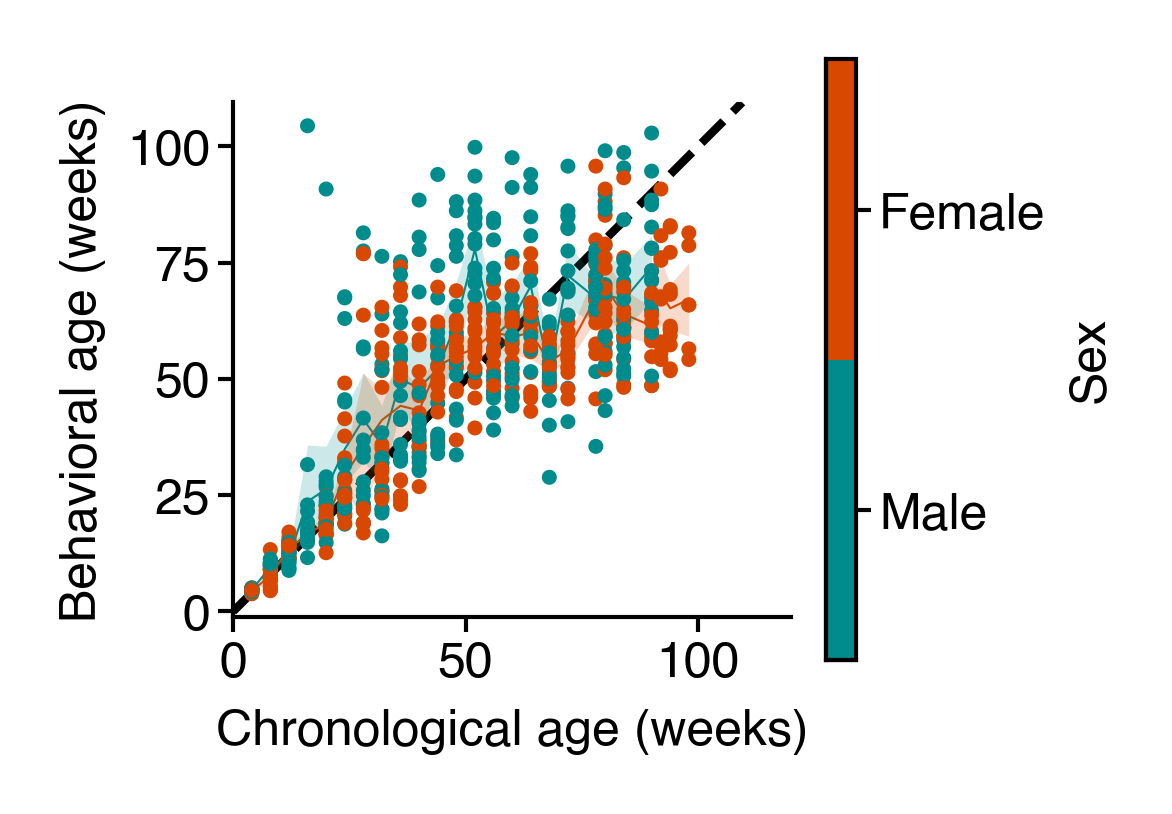

In [16]:
fig = make_plot(age_df, 1.5, 1.3)
saver(fig, "ontogeny-sex-chron-vs-beh-age-all-timepoints");

### At each chronological age, what is the male/female distribution of biological age?

In [17]:
age_df['bin'] = pd.cut(age_df['true_ages'], 8, labels=False)

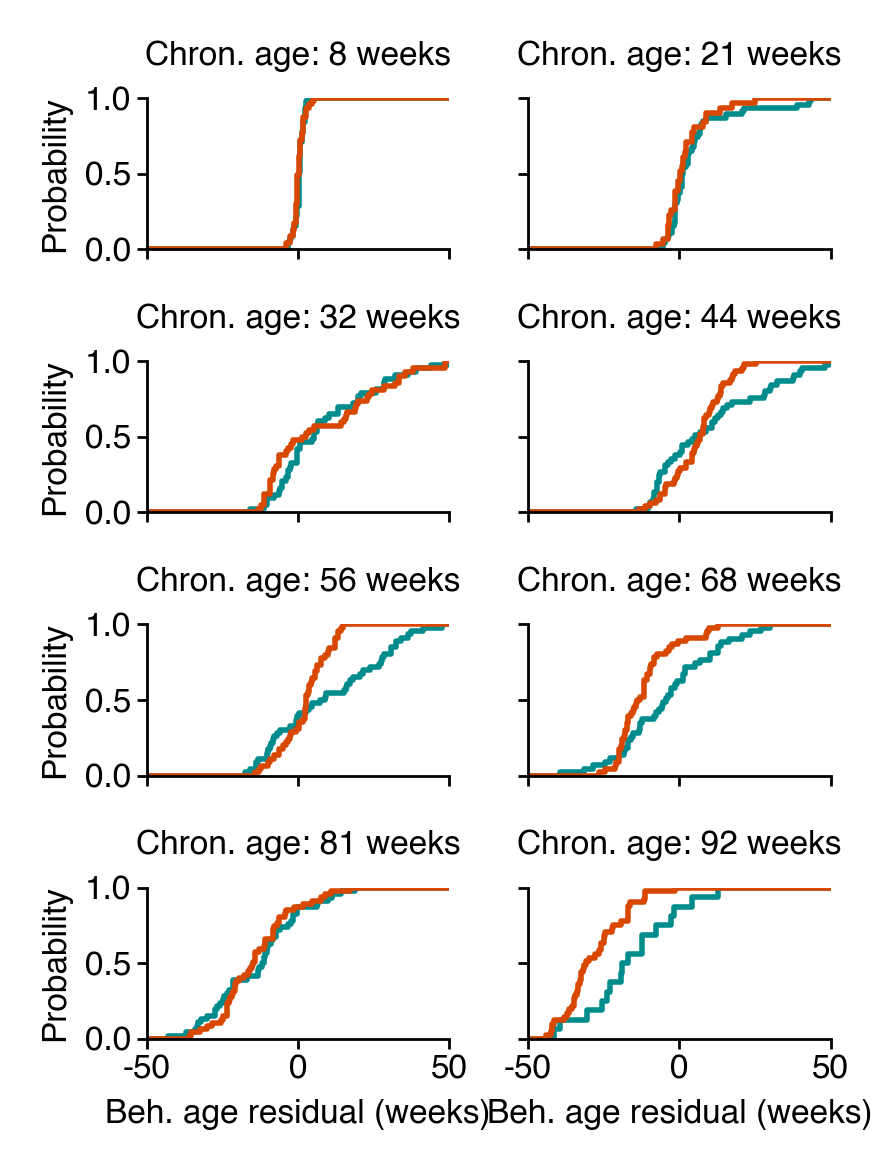

In [18]:
fig, ax = plt.subplots(4, 2, figsize=(2.2, 2.9), sharey=True, sharex=True)
for a, (_bin, _df) in zip(ax.flat, age_df.groupby("bin")):
    mean_age = _df["true_ages"].mean()
    _male_df = _df.query("labels == 0")
    _female_df = _df.query("labels == 1")
    sns.histplot(
        data=_male_df["bio_ages"] - _male_df['true_ages'],
        ax=a,
        color=COLORMAPS.ont_male(255),
        bins=np.linspace(-50, 50, 200),
        fill=False,
        cumulative=True,
        element="step",
        stat='probability',
    )
    sns.histplot(
        data=_female_df["bio_ages"] - _female_df['true_ages'],
        ax=a,
        color=COLORMAPS.ont_female(255),
        bins=np.linspace(-50, 50, 200),
        fill=False,
        cumulative=True,
        element="step",
        stat='probability',
    )
    a.set(title=f"Chron. age: {mean_age:0.0f} weeks", ylim=(0, 1))
for a in ax[-1]:
    a.set(xlabel="Beh. age residual (weeks)", xlim=(-50, 50))
sns.despine()
fig.tight_layout()
saver(fig, "male-female-difference-to-avg-chron-age");

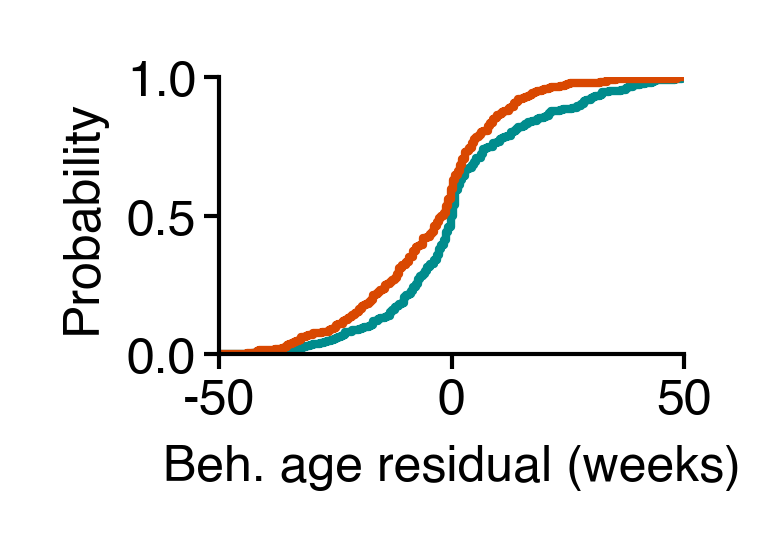

In [19]:
fig = figure(1, 0.6)
_male_df = age_df.query("labels == 0")
_female_df = age_df.query("labels == 1")
sns.histplot(
    data=_male_df["bio_ages"] - _male_df['true_ages'],
    color=COLORMAPS.ont_male(255),
    bins=np.linspace(-50, 50, 200),
    fill=False,
    cumulative=True,
    element="step",
    stat='probability',
)
a = sns.histplot(
    data=_female_df["bio_ages"] - _female_df['true_ages'],
    color=COLORMAPS.ont_female(255),
    bins=np.linspace(-50, 50, 200),
    fill=False,
    cumulative=True,
    element="step",
    stat='probability',
)
a.set(xlabel="Beh. age residual (weeks)", xlim=(-50, 50), ylim=(0, 1))
sns.despine()
saver(fig, "male-female-difference-to-avg-chron-age-combined");

In [20]:
ks_result = ks_2samp(_male_df['bio_ages'] - _male_df['true_ages'], _female_df['bio_ages'] - _female_df['true_ages'])
ks_result

KstestResult(statistic=0.13958338742200413, pvalue=0.002310284535603929, statistic_location=-10.451294, statistic_sign=-1)

## Sorting by model predictions

In [21]:
df_copy = df.copy().astype('float32')

# normalize to sum to 1
df_copy = df_copy / (df_copy.sum(1).to_numpy()[:, None])
df_copy['beh_age'] = mdl['bio_ages']
df_copy = df_copy.set_index('beh_age', append=True)
df_copy['age_bin'] = pd.cut(df_copy.index.get_level_values('age'), 24, labels=False)
df_copy['beh_age_bin'] = pd.cut(df_copy.index.get_level_values('beh_age'), 24, labels=False)
df_copy = df_copy.set_index(['beh_age_bin', 'age_bin'], append=True)

### Pre-bambi males and females

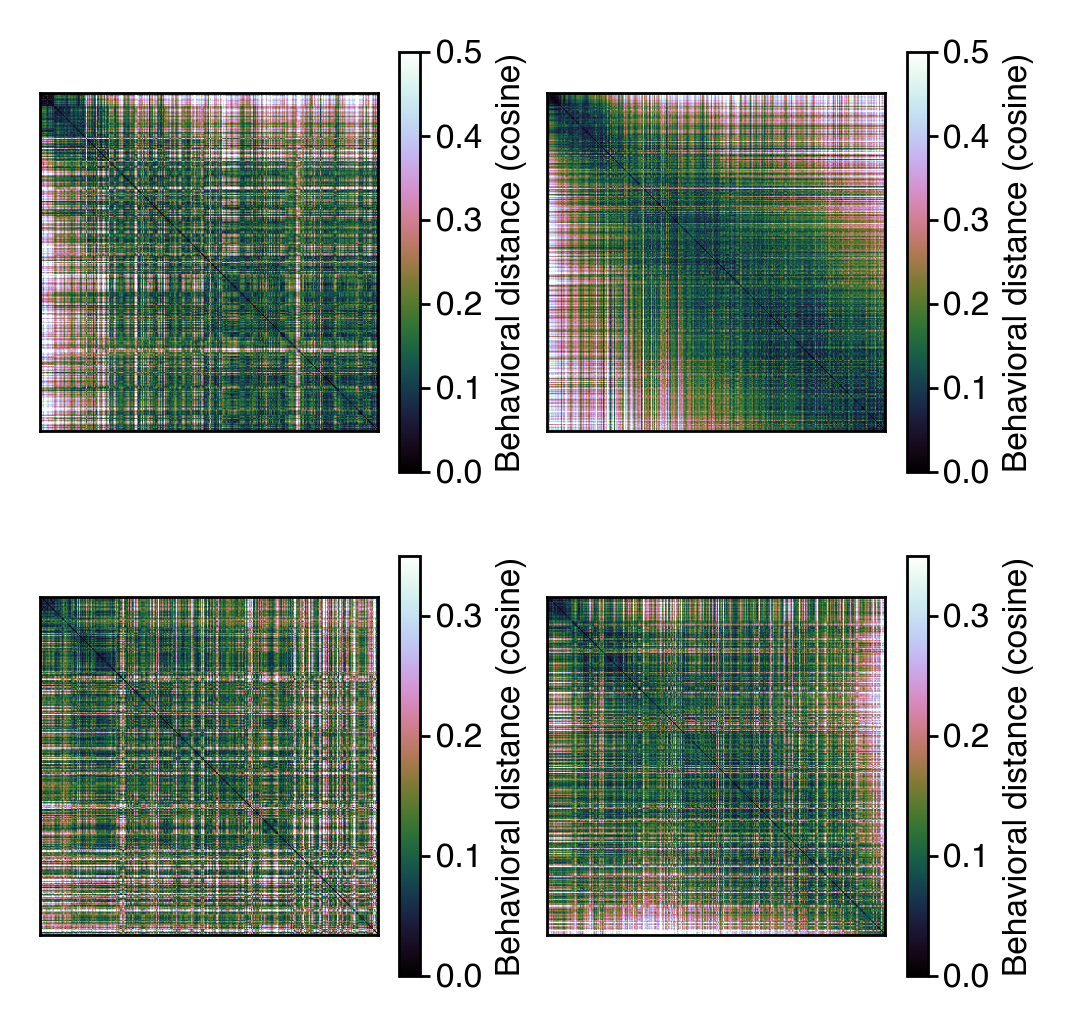

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(3, 3))

sex_vmap = {
    0: 0.5,
    1: 0.35,
}

for (_sex, _sorting), a in zip(product([0, 1], ["age", "beh_age"]), ax.flat):
    d = pdist(df_copy.query('sex == @_sex').sort_index(level=_sorting), metric="cosine")
    d = squareform(d)

    im = a.imshow(d, cmap="cubehelix", vmax=sex_vmap[_sex], vmin=0)
    fig.colorbar(im, ax=a, label="Behavioral distance (cosine)")
    a.set(xticks=[], yticks=[])
saver(fig, 'male-female-distance-matrix-pre-post-bambi-sorting-cosine');

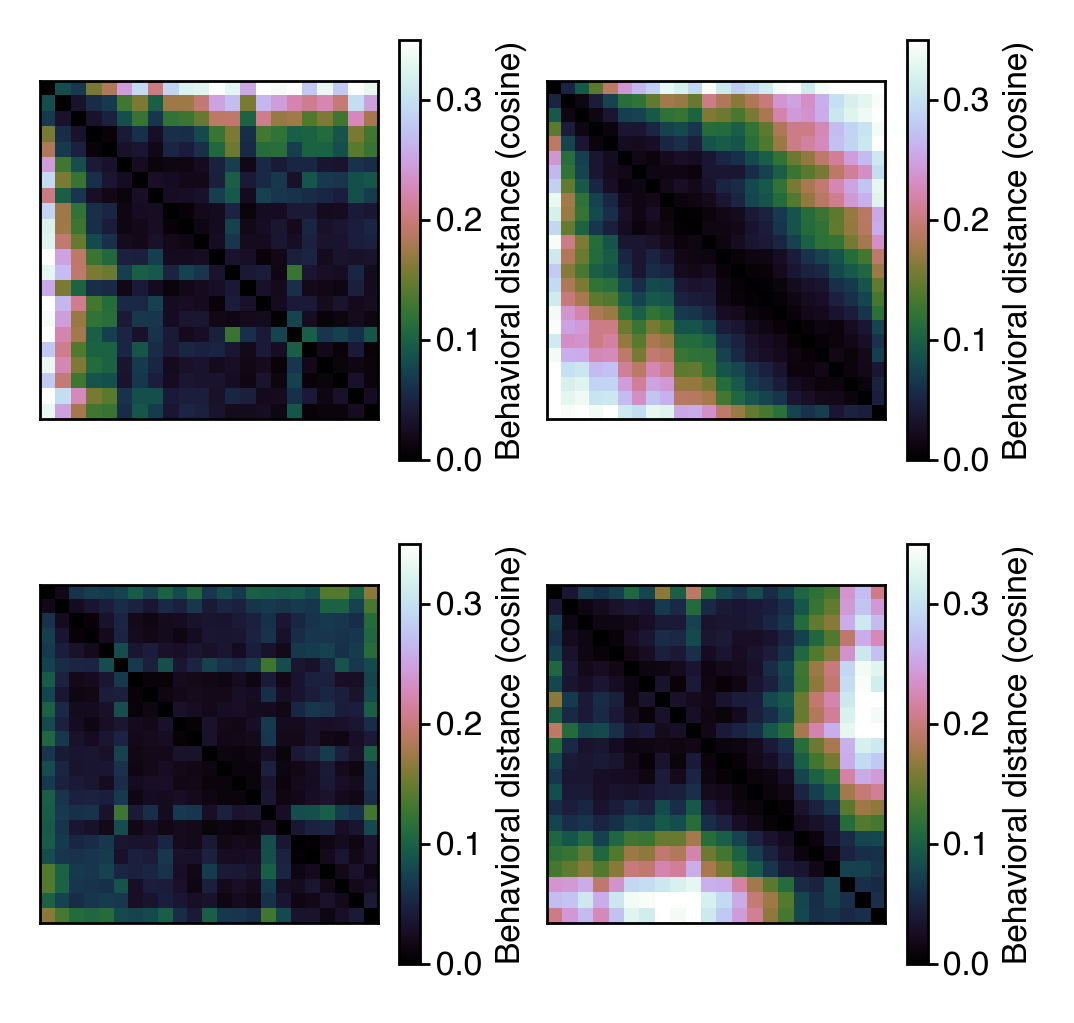

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(3, 3))

sex_vmap = {
    0: 0.35,
    1: 0.35,
}

for (_sex, _sorting), a in zip(product([0, 1], ["age_bin", "beh_age_bin"]), ax.flat):
    d = pdist(df_copy.query('sex == @_sex').groupby(_sorting).mean(), metric="cosine")
    d = squareform(d)

    im = a.imshow(d, cmap="cubehelix", vmax=sex_vmap[_sex], vmin=0)
    fig.colorbar(im, ax=a, label="Behavioral distance (cosine)")
    a.set(xticks=[], yticks=[])
saver(fig, 'ontogeny-averaged-distance-matrix-pre-post-bambi-sorting-cosine');

## PCA on model predictions

In [24]:
pc = mdl['predicted_counts']
pc = pc / pc.sum(1, keepdims=True)

In [25]:
pca = PCA(n_components=2)
scores = pca.fit_transform(pc)
scores_df = pd.DataFrame(scores, index=df.index)
scores_df['bio_age'] = mdl['bio_ages']

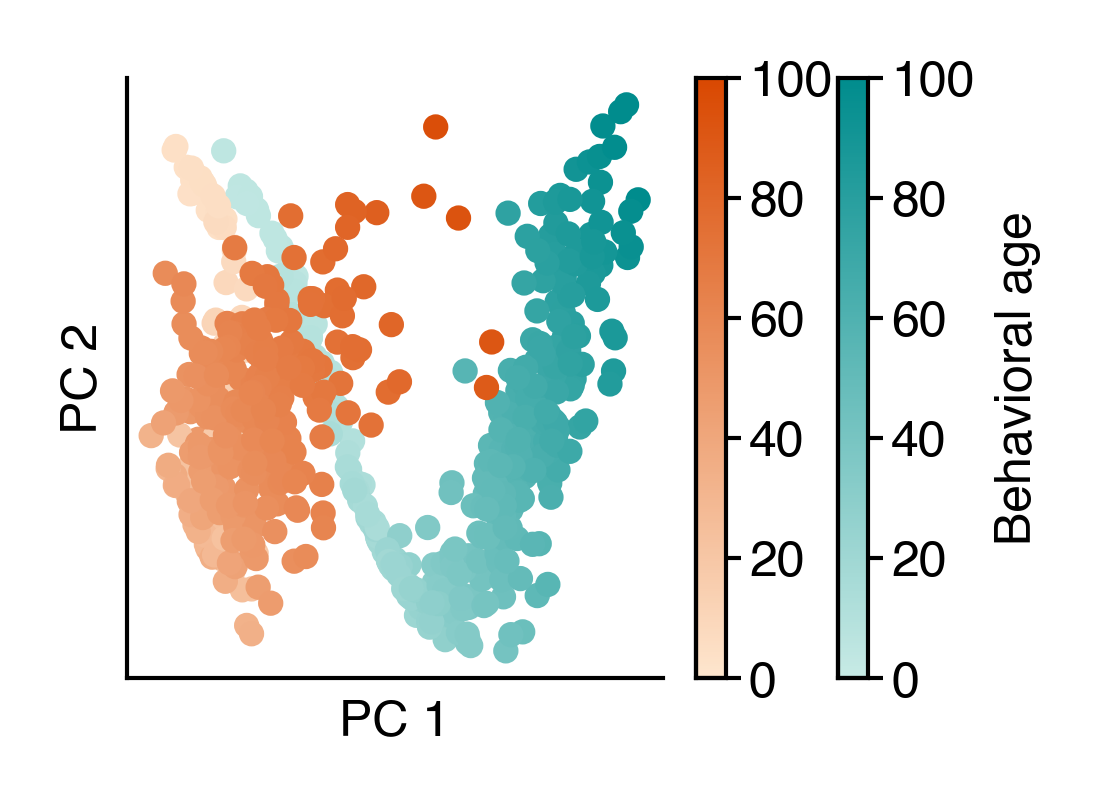

In [26]:
fig = figure(1.8, 1.3)
ax = fig.gca()
for sex, _df in scores_df.groupby('sex'):
    cm = COLORMAPS.ont_male if sex == 0 else COLORMAPS.ont_female
    im = ax.scatter(_df[0], _df[1], c=_df['bio_age'], cmap=cm, s=5, vmin=0, vmax=100)
    cb = fig.colorbar(im, ax=ax, label="Behavioral age" if sex == 0 else None)
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, "model-based-pca-males-females-bio-age");

## Plot age likelihoods

In [27]:
_age = mdl['init_components'].age_unnormalizer(mdl['init_components'].age_samples)

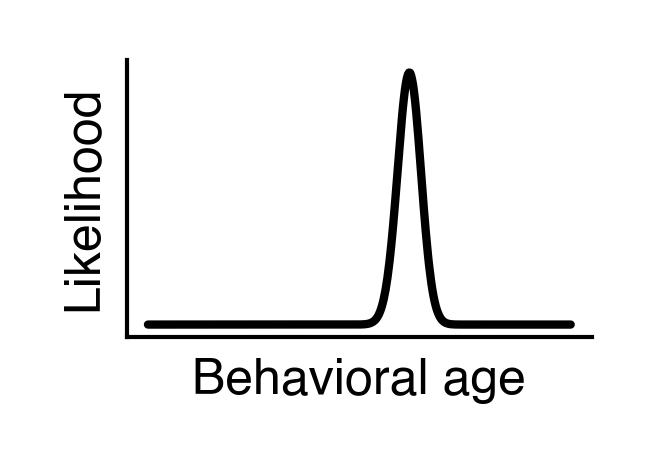

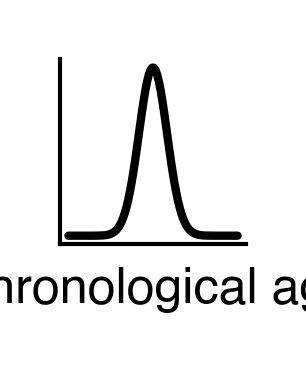

In [28]:
# bambi likelihood
fig = figure(1, 0.6)
ax = fig.gca()
ax.plot(_age, mdl['age_likelihoods'][100], color='k')
ax.set(xticks=[], yticks=[], xlabel="Behavioral age", ylabel="Likelihood")
sns.despine()
saver(fig, "beh-age-likelihood-function-schematic");

# gaussian likelihood
out = norm.pdf(np.linspace(-6, 6, 100), loc=0, scale=1)

fig = figure(0.4, 0.4)
ax = fig.gca()
ax.plot(out, color='k')
ax.set(xticks=[], yticks=[], xlabel="Chronological age")
sns.despine()
saver(fig, "chron-age-prior-schematic");

## Relative contributions

In [29]:
mdl_params = mdl['params']
mdl_components = mdl['init_components']
bias_scale = np.exp(mdl_params['development_weights'] @ mdl_components.bases['development'])
list(mdl_params)

['bio_basis_weights', 'development_weights', 'individual_biases', 'size_slope']

### Size

In [30]:
size_effect = np.abs(mdl_params['size_slope'].squeeze())

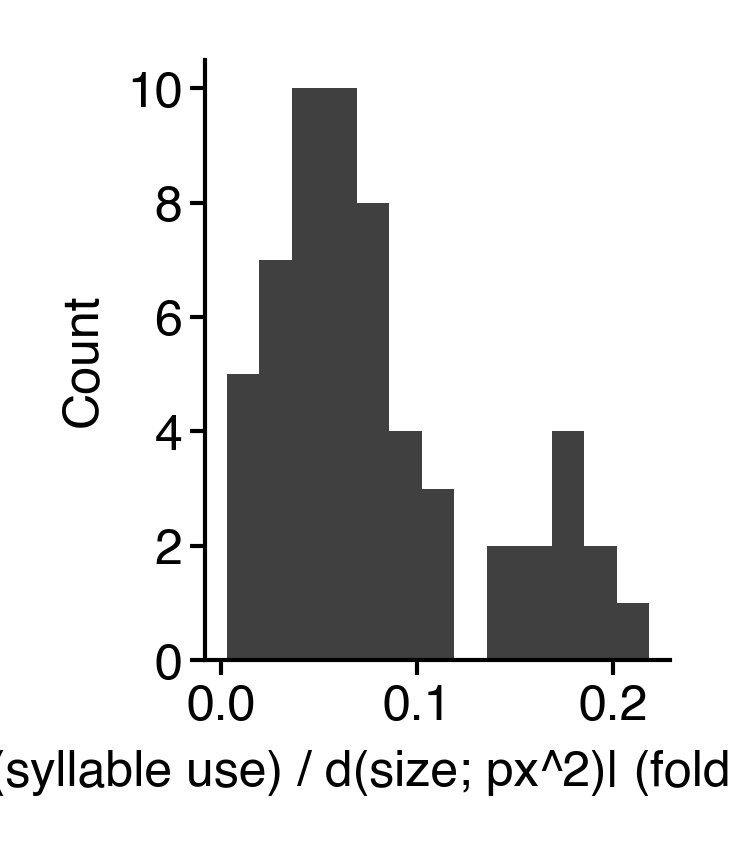

In [31]:
# size plot - histogram of slopes across syllables
fig = figure(1, 1.3)

ax = sns.histplot(size_effect, bins=13, element='step', fill=True, linewidth=0, color="k")
ax.set(xlabel="|d(syllable use) / d(size; px^2)| (fold-change)")
sns.despine()
saver(fig, "size-deriv-histogram");

### Age

In [32]:
def get_component_diffs(comp, age1, age2):
    x = np.interp(mdl_components.age_normalizer(np.array([age1, age2])), mdl_components.age_samples, comp)
    return x[1] - x[0], age2 - age1

def get_spline_diffs(splines, age1, age2, syllable):
    '''returns the difference in spline values and the difference in ages'''
    return get_component_diffs(splines[syllable], age1, age2)

In [33]:
splines = mdl_params['bio_basis_weights'] @ mdl_components.bases['bio']

bio_deriv = np.diff(splines, axis=1)

true_age = mdl_components.age_unnormalizer(mdl_components.age_samples)
age_diff = np.diff(true_age)

bio_deriv_norm = bio_deriv / age_diff[None]

In [34]:
def get_bio_deriv(age, syllable):
    '''age can be a vector or scalar.
    Syllable should be an int from 0-58'''
    return np.interp(age, true_age[:-1], bio_deriv_norm[syllable])

In [35]:
deriv_df = pd.DataFrame(bio_deriv_norm.T, columns=pd.Index(df.columns, name="syllable"), index=pd.Index(true_age[:-1], name="age")).abs()
melt_deriv_df = deriv_df.reset_index().melt(id_vars='age').query('age < 100 & age > 4')

In [36]:
melt_deriv_df

age syllable     value
77      4.011278        0  0.027671
78      4.026440        0  0.026678
79      4.041659        0  0.025693
80      4.056936        0  0.024718
81      4.072270        0  0.023751
...          ...      ...       ...
57868  98.332550       98  0.029676
57869  98.704231       98  0.029714
57870  99.077309       98  0.029749
57871  99.451820       98  0.029788
57872  99.827728       98  0.029824

[49474 rows x 3 columns]

/tmp/ipykernel_25651/424691499.py:2: UserWarning: 
The palette list has fewer values (1) than needed (58) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(


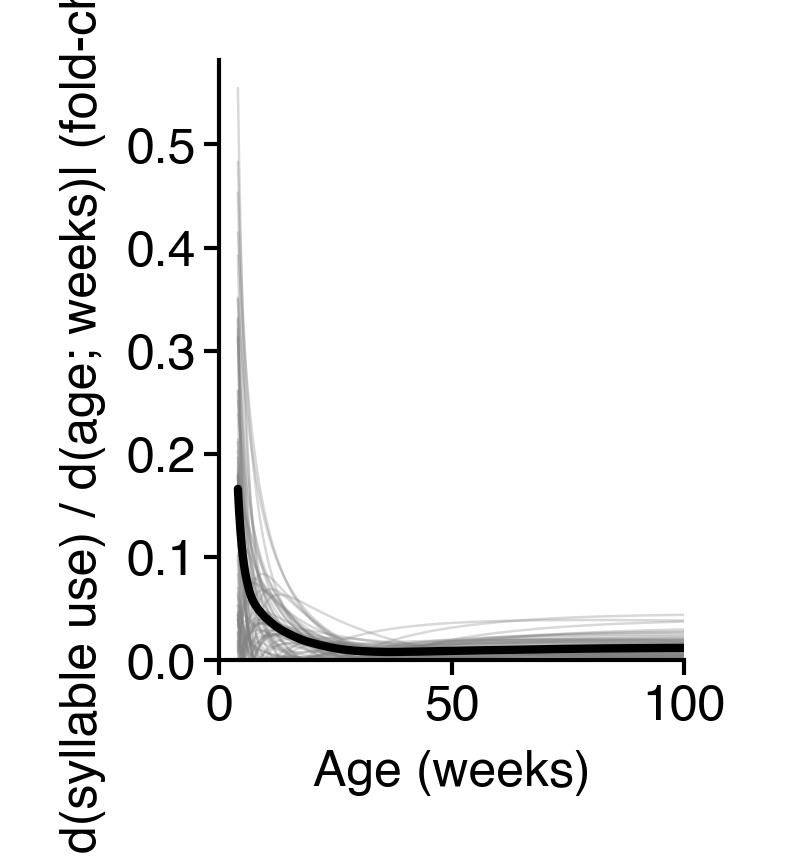

In [37]:
fig = figure(1, 1.3)
ax = sns.lineplot(
    data=melt_deriv_df,
    x="age",
    y="value",
    hue="syllable",
    errorbar=None,
    err_kws=dict(lw=0),
    palette=["gray"],
    legend=False,
    linewidth=0.3,
    alpha=0.3,
)
ax = sns.lineplot(
    data=melt_deriv_df,
    x="age",
    y="value",
    errorbar=None,
    err_kws=dict(lw=0),
    color='k',
    legend=False,
    linewidth=1,
    alpha=1,
    ax=ax
)
ax.set(
    xlabel="Age (weeks)",
    ylabel="|d(syllable use) / d(age; weeks)| (fold-change)",
    xlim=(0, 100),
    ylim=(0, None),
)
sns.despine()
saver(fig, "age-deriv-lineplot");

### Sex

In [38]:
sex_bias = np.array(raise_dim(mdl_params['individual_biases'], axis=1))
sex_bias_effect = np.mean(np.abs(sex_bias), axis=1).squeeze()
sex_bias_effect_w_scaling = (bias_scale * sex_bias_effect[:, None])

In [39]:
sex_deriv_df = pd.DataFrame(sex_bias_effect_w_scaling.T, columns=pd.Index(df.columns, name="syllable"), index=pd.Index(true_age, name="age")).abs()
melt_sex_deriv_df = sex_deriv_df.reset_index().melt(id_vars='age').query('age < 100 & age > 4')

/tmp/ipykernel_25651/2134615969.py:2: UserWarning: 
The palette list has fewer values (1) than needed (58) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(


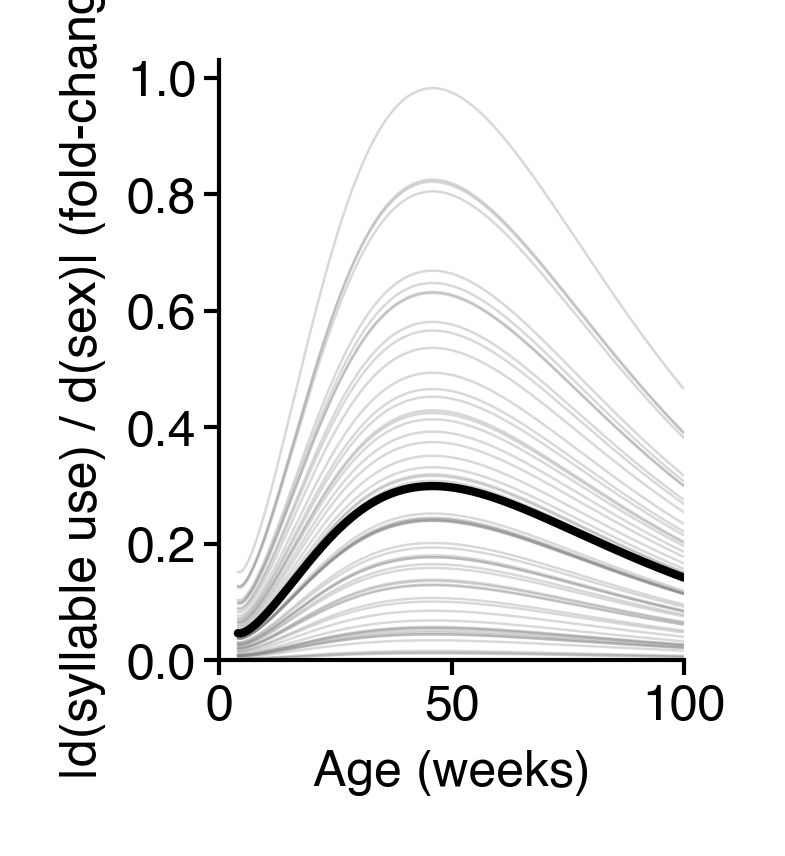

In [40]:
fig = figure(1, 1.3)
ax = sns.lineplot(
    data=melt_sex_deriv_df,
    x="age",
    y="value",
    hue="syllable",
    errorbar=None,
    err_kws=dict(lw=0),
    palette=["gray"],
    legend=False,
    linewidth=0.3,
    alpha=0.3,
)
ax = sns.lineplot(
    data=melt_sex_deriv_df,
    x="age",
    y="value",
    errorbar=None,
    err_kws=dict(lw=0),
    color='k',
    legend=False,
    linewidth=1,
    alpha=1,
    ax=ax,
)
ax.set(
    xlabel="Age (weeks)",
    ylabel="|d(syllable use) / d(sex)| (fold-change)",
    xlim=(0, 100),
    ylim=(0, None),
)
sns.despine()
saver(fig, "sex-deriv-lineplot");

### Rank-order each syllable + effect

In [41]:
sex_rank = np.argsort(np.argsort(sex_deriv_df.mean().values))
size_rank = np.argsort(np.argsort(size_effect))
age_rank = np.argsort(np.argsort(deriv_df.mean().values))

In [42]:
rank_df = pd.DataFrame(dict(sex=sex_rank, size=size_rank, age=age_rank), index=pd.Index(range(len(sex_rank)), name="syll_idx"))

In [43]:
melt_rank_df = rank_df.reset_index().melt(id_vars='syll_idx')

In [44]:
melt_rank_df

syll_idx variable  value
0           0      sex     17
1           1      sex     20
2           2      sex     39
3           3      sex     49
4           4      sex     18
..        ...      ...    ...
169        53      age     30
170        54      age      9
171        55      age     27
172        56      age     57
173        57      age     40

[174 rows x 3 columns]

In [45]:
age_rank_map = rank_df['age']

In [46]:
melt_rank_df['age_rank_map'] = melt_rank_df['syll_idx'].map(age_rank_map)

/tmp/ipykernel_25651/1766685904.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(ylabel="Syllable rank", xlabel="Factor", xticklabels=["Age", "Sex", "Size"])


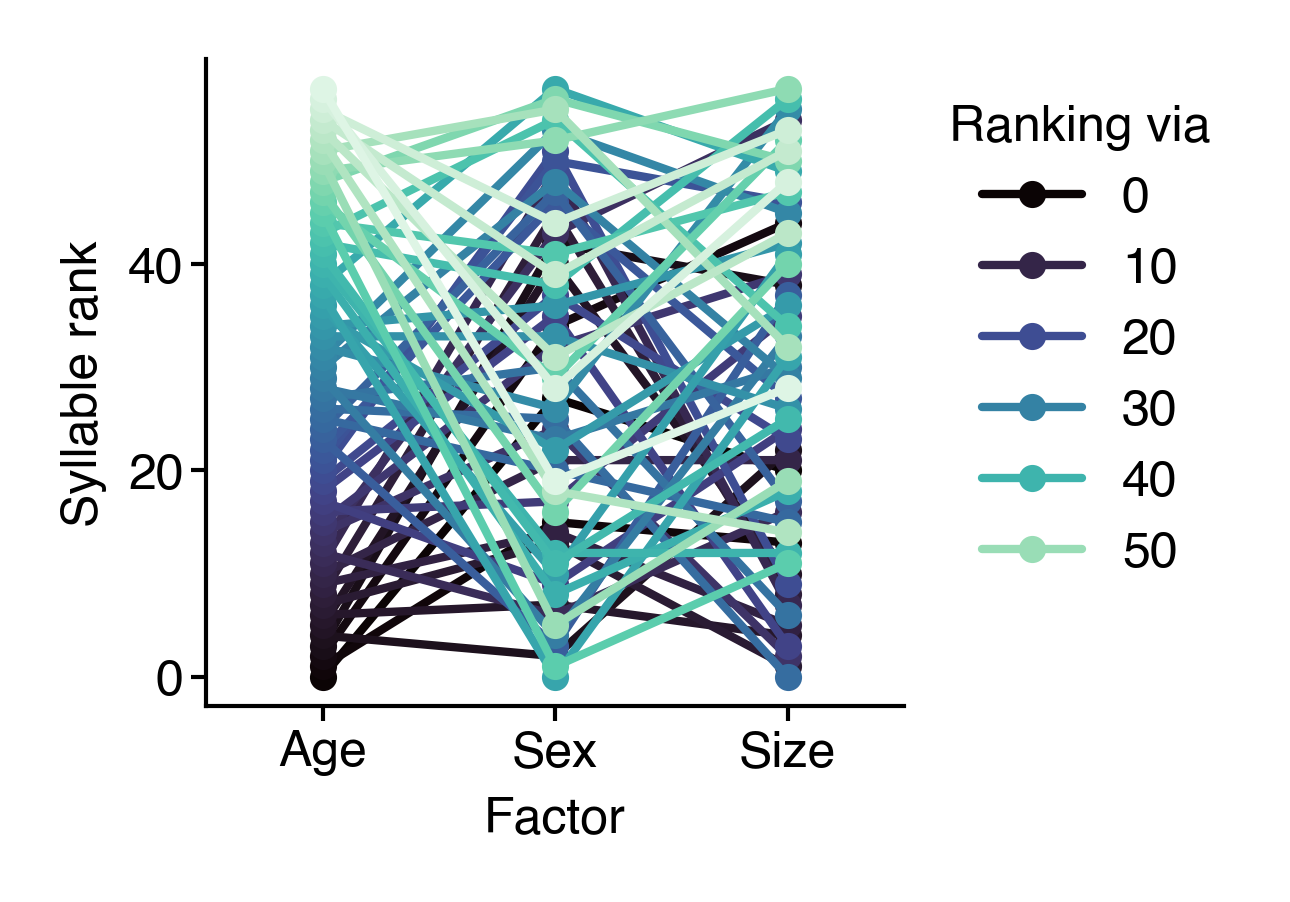

In [47]:
fig = figure(1.5, 1.4)
ax = sns.pointplot(data=melt_rank_df, x='variable', y='value', hue='age_rank_map', order=['age', 'sex', 'size'], palette='mako', linewidth=1)
ax.set(ylabel="Syllable rank", xlabel="Factor", xticklabels=["Age", "Sex", "Size"])
legend(ax, title="Ranking via")
sns.despine()
saver(fig, "bambi-factor-syllable-derivative-ranking");

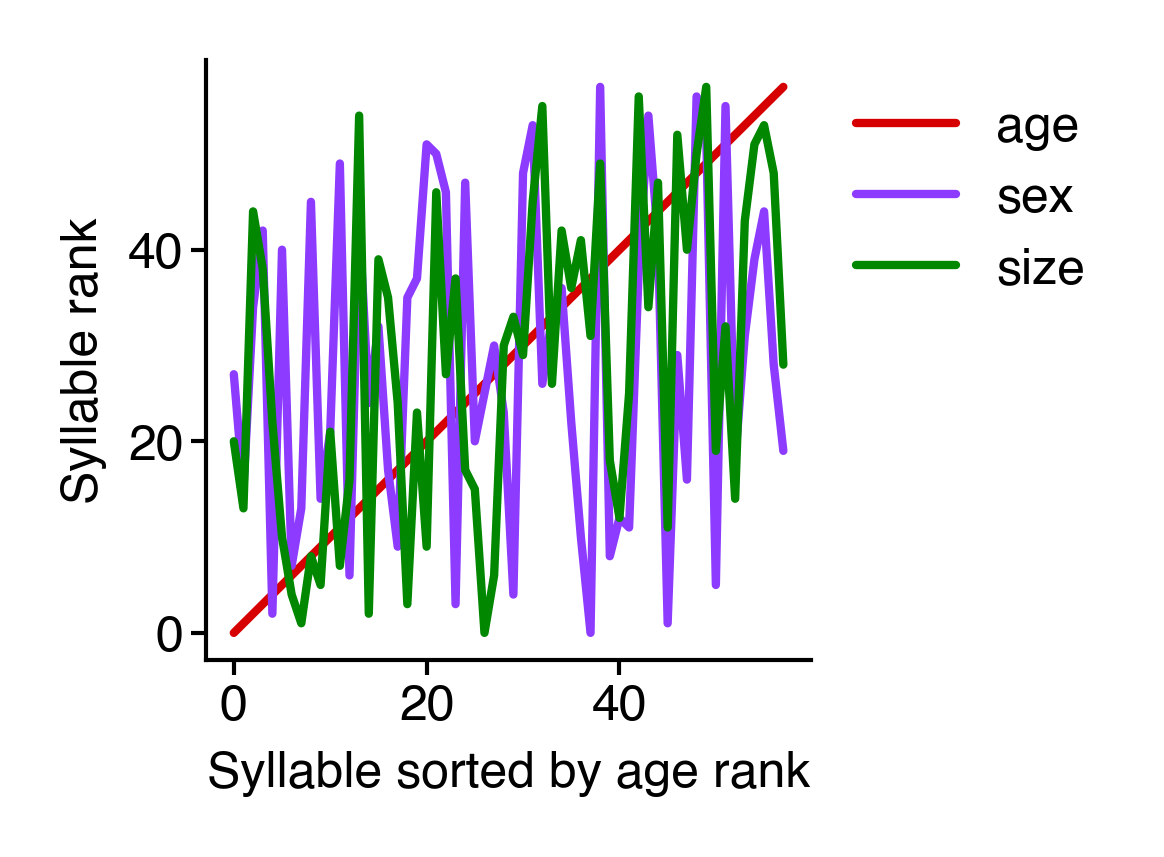

In [48]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(
    data=melt_rank_df,
    x="age_rank_map",
    y="value",
    hue="variable",
    hue_order=["age", "sex", "size"],
    palette=cc.glasbey[:3],
    linewidth=1,
)
ax.set(ylabel="Syllable rank", xlabel="Syllable sorted by age rank")
legend(ax)
sns.despine()
saver(fig, "sorted-factor-rankings");

## Make plots showing high-influence syllables are better predicting than low-influence syllables

In [49]:
from sklearn.svm import SVC, SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import accuracy_score, r2_score

In [50]:
clf_data = df.reset_index().assign(bio_age=mdl['bio_ages'])

In [51]:
melt_rank_df = rank_df.reset_index().melt(id_vars='syll_idx')

In [52]:
syll_factors = rank_df.idxmax(1)

In [53]:
grp_ranks = {}
for grp, ser in syll_factors.groupby(syll_factors):
    grp_ranks[grp] = rank_df.loc[ser.index, grp].sort_values(ascending=False)

In [54]:
valmap(len, grp_ranks)

{'age': 15, 'sex': 25, 'size': 18}

In [55]:
pipe = make_pipeline(
    StandardScaler(),
    # LinearRegression(),
    # SVR(),
    PLSRegression(n_components=2),
    # ElasticNet(l1_ratio=0.5, alpha=5),
)

In [56]:
top_n = 10
filt_sylls = {k: v.index[:top_n] for k, v in grp_ranks.items()}

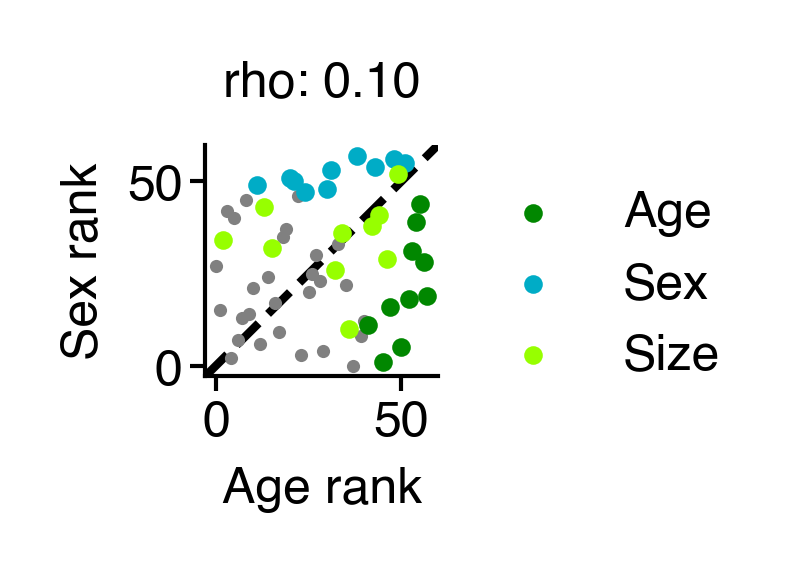

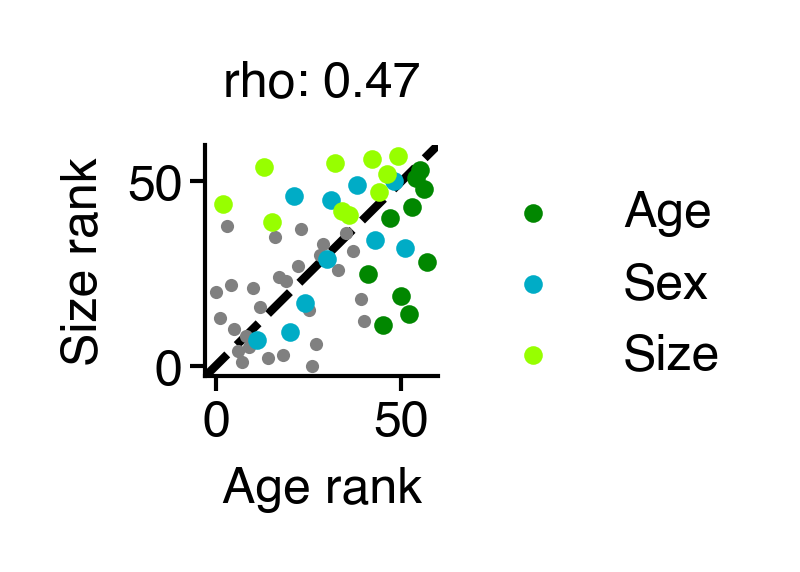

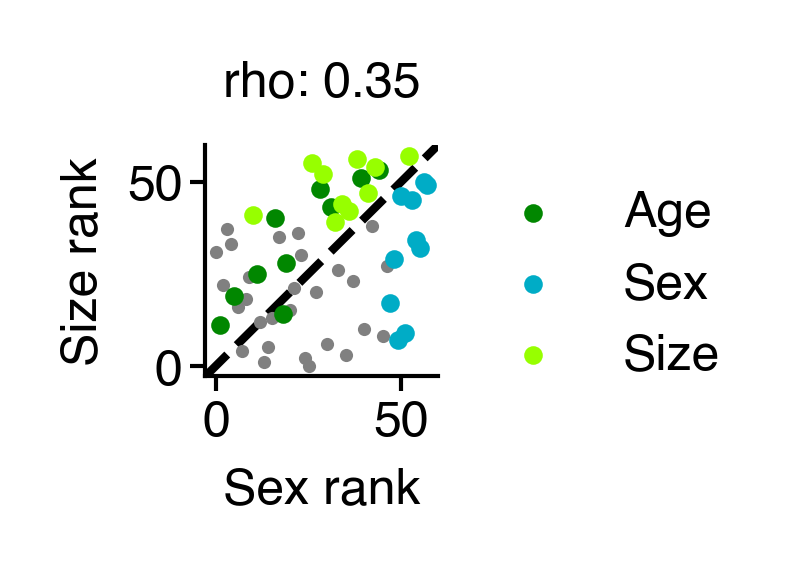

In [57]:
colors = dict(zip(['age', 'sex', 'size'], cc.glasbey[2:]))

for t1, t2 in combinations(['age', 'sex', 'size'], 2):
    fig = figure(0.5, 0.5)
    ax = fig.gca()
    c = rank_df[t1].corr(rank_df[t2], method='spearman')
    ax.scatter(rank_df[t1], rank_df[t2], s=2.5, linewidth=0, color='gray')
    for _factor, _color in colors.items():
        ax.scatter(rank_df.loc[filt_sylls[_factor], t1], rank_df.loc[filt_sylls[_factor], t2], s=5, linewidth=0, color=colors[_factor], label=_factor.capitalize())
    add_identity(ax, ls='--', color='k', zorder=-1)
    legend(ax)
    ax.set(xlabel=f"{t1.capitalize()} rank", ylabel=f"{t2.capitalize()} rank", title=f"rho: {c:0.2f}")
    sns.despine()

    saver(fig, f"{t1}-{t2}-rank-comparison");

/home/wg41/miniconda3/envs/aging-gpu/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


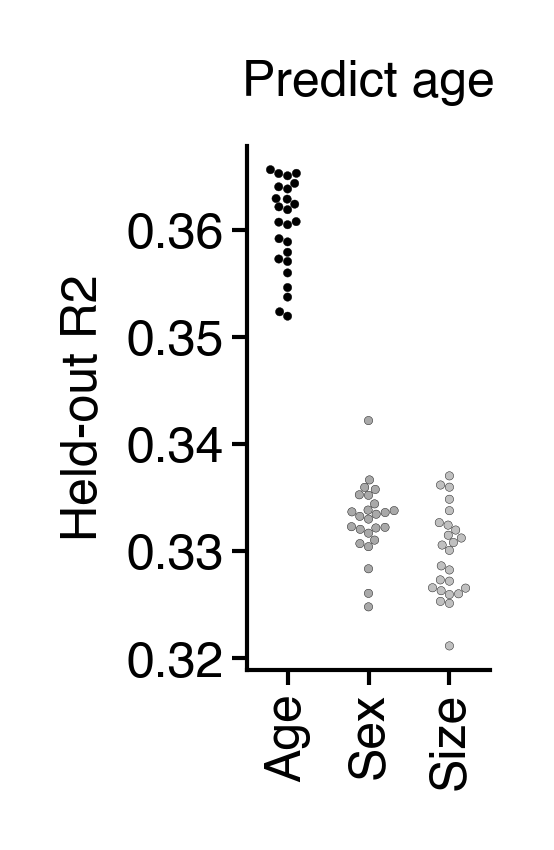

In [58]:
n_repeats = 25
x = []

for rank_grp, _df in filt_sylls.items():
    for i in range(n_repeats):
        preds = cross_val_predict(
            pipe,
            np.array(syllable_counts_jax[:, _df.values]),
            clf_data["age"],
            # clf_data["bio_age"],
            cv=KFold(n_splits=5, shuffle=True, random_state=i),
            n_jobs=-1,
        )
        x.append({"r2": r2_score(clf_data["age"], preds), "type": rank_grp.capitalize()})
x = pd.DataFrame(x)


fig = figure(0.9, 1.4)
ax = sns.swarmplot(data=x, x='type', y='r2', hue='type', palette=['k', 'darkgray', 'silver'], size=1, linewidth=0.05)
plt.xticks(rotation=90)
ax.set(ylabel="Held-out R2", xlabel="", title="Predict age")
sns.despine()
saver(fig, "predict-age-from-syllables", tight_layout=True);

/home/wg41/miniconda3/envs/aging-gpu/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/wg41/miniconda3/envs/aging-gpu/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


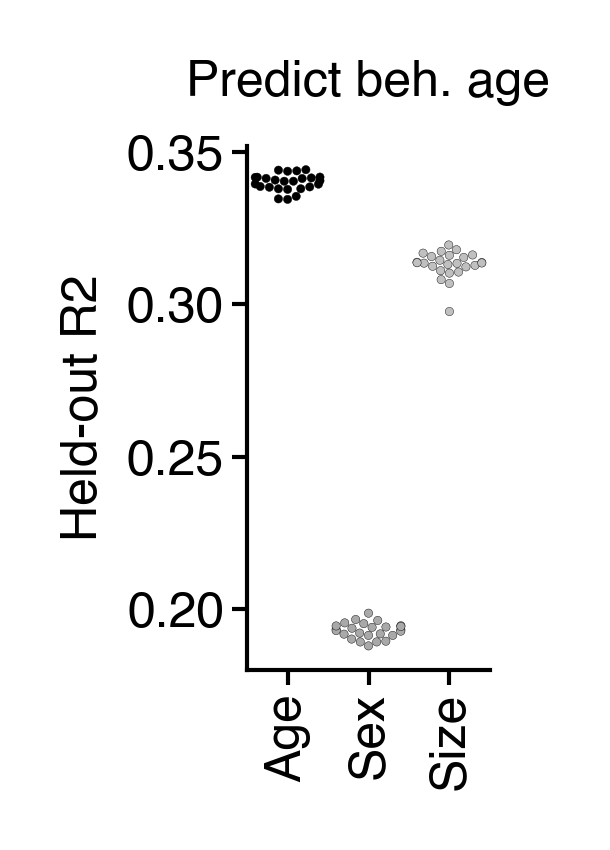

In [59]:
n_repeats = 25
x = []

for rank_grp, _df in filt_sylls.items():
    for i in range(n_repeats):
        preds = cross_val_predict(
            pipe,
            np.array(syllable_counts_jax[:, _df.values]),
            clf_data["bio_age"],
            cv=KFold(n_splits=5, shuffle=True, random_state=i),
            n_jobs=-1,
        )
        x.append({"r2": r2_score(clf_data["age"], preds), "type": rank_grp.capitalize()})
x = pd.DataFrame(x)


fig = figure(0.9, 1.4)
ax = sns.swarmplot(data=x, x='type', y='r2', hue='type', palette=['k', 'darkgray', 'silver'], size=1, linewidth=0.05)
plt.xticks(rotation=90)
ax.set(ylabel="Held-out R2", xlabel="", title="Predict beh. age")
sns.despine()
saver(fig, "predict-beh-age-from-syllables", tight_layout=True);

/home/wg41/miniconda3/envs/aging-gpu/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/wg41/miniconda3/envs/aging-gpu/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


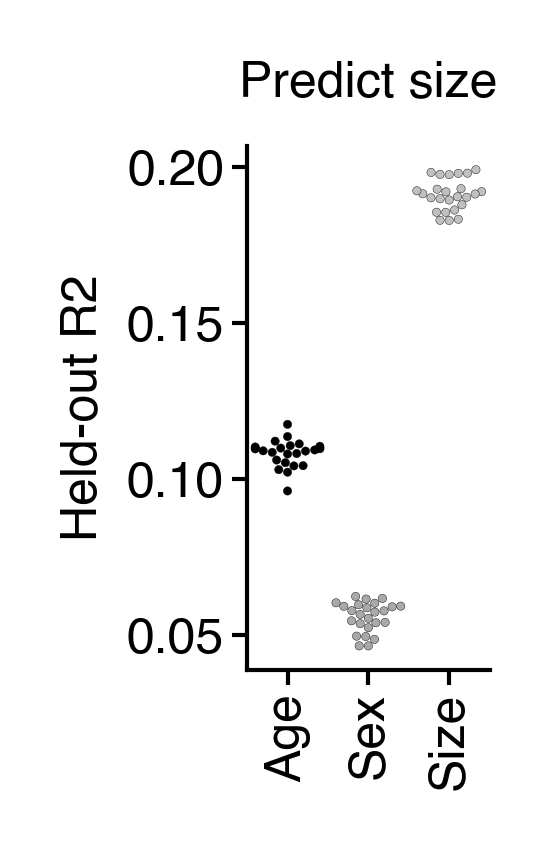

In [60]:
n_repeats = 25
x = []

y = np.array(features['sizes'])

for rank_grp, _df in filt_sylls.items():
    for i in range(n_repeats):
        preds = cross_val_predict(
            pipe,
            np.array(syllable_counts_jax[:, _df.values]),
            y,
            cv=KFold(n_splits=5, shuffle=True, random_state=i),
            n_jobs=-1,
        )
        x.append({"r2": r2_score(y, preds), "type": rank_grp.capitalize()})
x = pd.DataFrame(x)

fig = figure(0.9, 1.4)
ax = sns.swarmplot(data=x, x='type', y='r2', hue='type', palette=['k', 'darkgray', 'silver'], size=1, linewidth=0.05)
plt.xticks(rotation=90)
ax.set(ylabel="Held-out R2", xlabel="", title="Predict size")
sns.despine()
saver(fig, "predict-size-from-syllables", tight_layout=True);

In [61]:
clf_pipe = make_pipeline(
    StandardScaler(),
    SVC(kernel='linear', class_weight='balanced'),
)

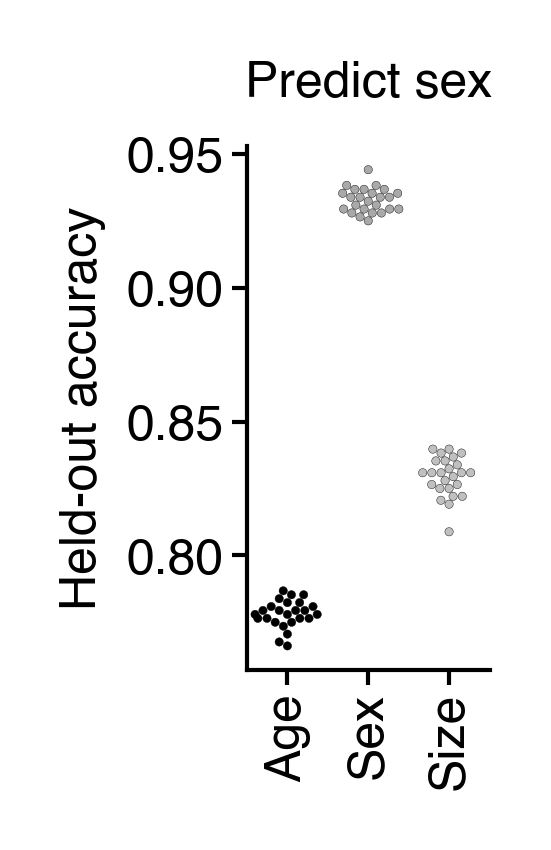

In [62]:
n_repeats = 25
x = []

y = np.argmax(features['mice'], axis=0)

for rank_grp, _df in filt_sylls.items():
    for i in range(n_repeats):
        preds = cross_val_predict(
            clf_pipe,
            np.array(syllable_counts_jax[:, _df.values]),
            y,
            cv=KFold(n_splits=5, shuffle=True, random_state=i),
            n_jobs=-1,
        )
        x.append({"acc": accuracy_score(y, preds), "type": rank_grp.capitalize()})
x = pd.DataFrame(x)


fig = figure(0.9, 1.4)
ax = sns.swarmplot(data=x, x='type', y='acc', hue='type', palette=['k', 'darkgray', 'silver'], size=1, linewidth=0.05)
plt.xticks(rotation=90)
ax.set(ylabel="Held-out accuracy", xlabel="", title="Predict sex")
sns.despine()
saver(fig, "predict-sex-from-syllables", tight_layout=True);

## NMF

### Males

In [63]:
mask = df.index.get_level_values('sex') == 0

nmf_df = pd.DataFrame(dict(age=mdl['true_ages'], bio_age=mdl['bio_ages']), index=df.index).loc[mask].copy()

_age = nmf_df['age'].to_numpy()
nmf_df = nmf_df.sort_values(by='bio_age')
nmf_df['bio_age_map'] = _age
nmf_df = nmf_df.loc[df.index[mask]]

In [64]:
nmf_components = 3
nmf = NMF(n_components=nmf_components, random_state=0, max_iter=2_000)
scores = nmf.fit_transform(minmax(df.loc[mask].copy()))
nmf_keys = [f"{c + 1}" for c in range(nmf_components)]
nmf_df[nmf_keys] = scores

In [65]:
# joblib.dump(nmf.components_, '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/male-nmf-components.p')
# nmf_df.to_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/male-nmf-scores.parquet')

In [66]:
chron_avg = nmf_df.groupby(level='age')[nmf_keys].mean()
bio_avg = nmf_df.groupby('bio_age_map')[nmf_keys].mean()

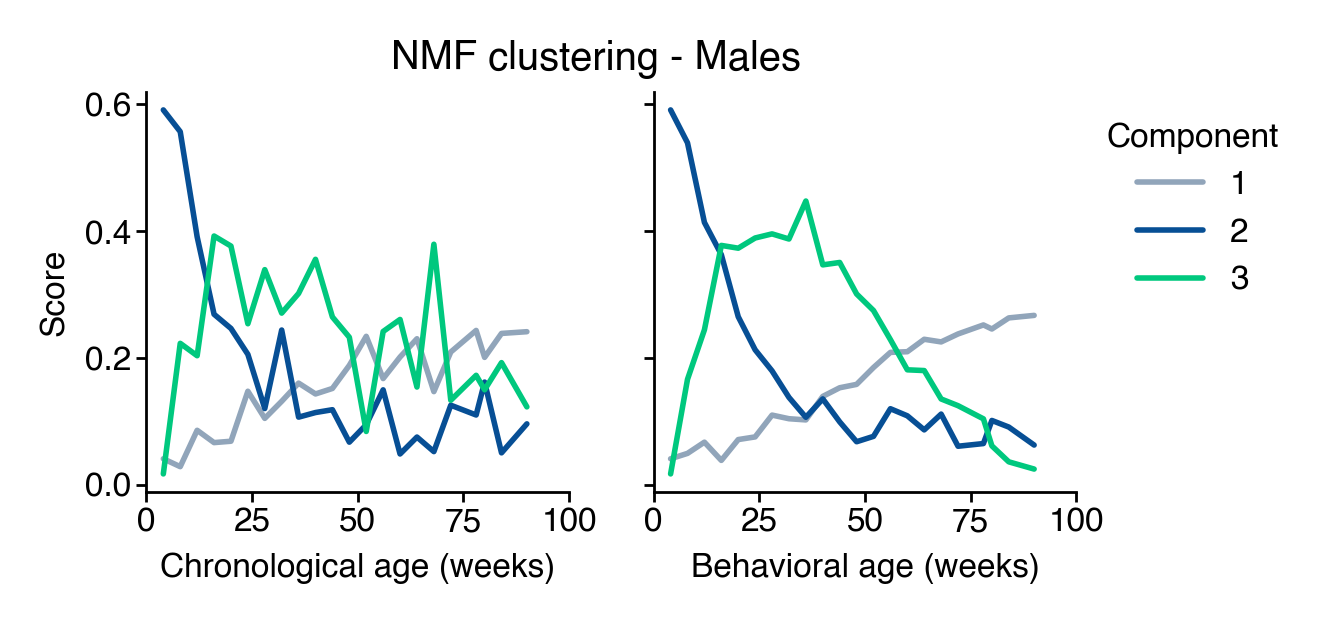

In [67]:
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey_cool[15:])}):
    fig, ax = plt.subplots(1, 2, figsize=(3, 1.3), sharey=True, sharex=True)
    a = chron_avg.plot(ax=ax[0], legend=False)
    a.set(xlabel="Chronological age (weeks)", ylabel="Score")
    a2 = bio_avg.plot(ax=ax[1])
    a2.set(xlabel="Behavioral age (weeks)", ylabel="Score", xlim=(0, 100))
    legend(a2, title="Component")
    sns.despine()
    fig.suptitle("NMF clustering - Males")
    saver(fig, "nmf-components-pre-post-sorting-blue-colors");

### Females

In [68]:
mask = df.index.get_level_values('sex') == 1

nmf_df = pd.DataFrame(dict(age=mdl['true_ages'], bio_age=mdl['bio_ages']), index=df.index).loc[mask].copy()

_age = nmf_df['age'].to_numpy()
nmf_df = nmf_df.sort_values(by='bio_age')
nmf_df['bio_age_map'] = _age
nmf_df = nmf_df.loc[df.index[mask]]

In [69]:
nmf = NMF(n_components=nmf_components, random_state=0, max_iter=2_000)
scores = nmf.fit_transform(minmax(df.loc[mask].copy()))
nmf_keys = [f"{c + 1}" for c in range(nmf_components)]
nmf_df[nmf_keys] = scores

In [70]:
# joblib.dump(nmf.components_, '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/female-nmf-components.p')
# nmf_df.to_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/female-nmf-scores.parquet')

In [71]:
chron_avg = nmf_df.groupby(level='age')[nmf_keys].mean()
bio_avg = nmf_df.groupby('bio_age_map')[nmf_keys].mean()

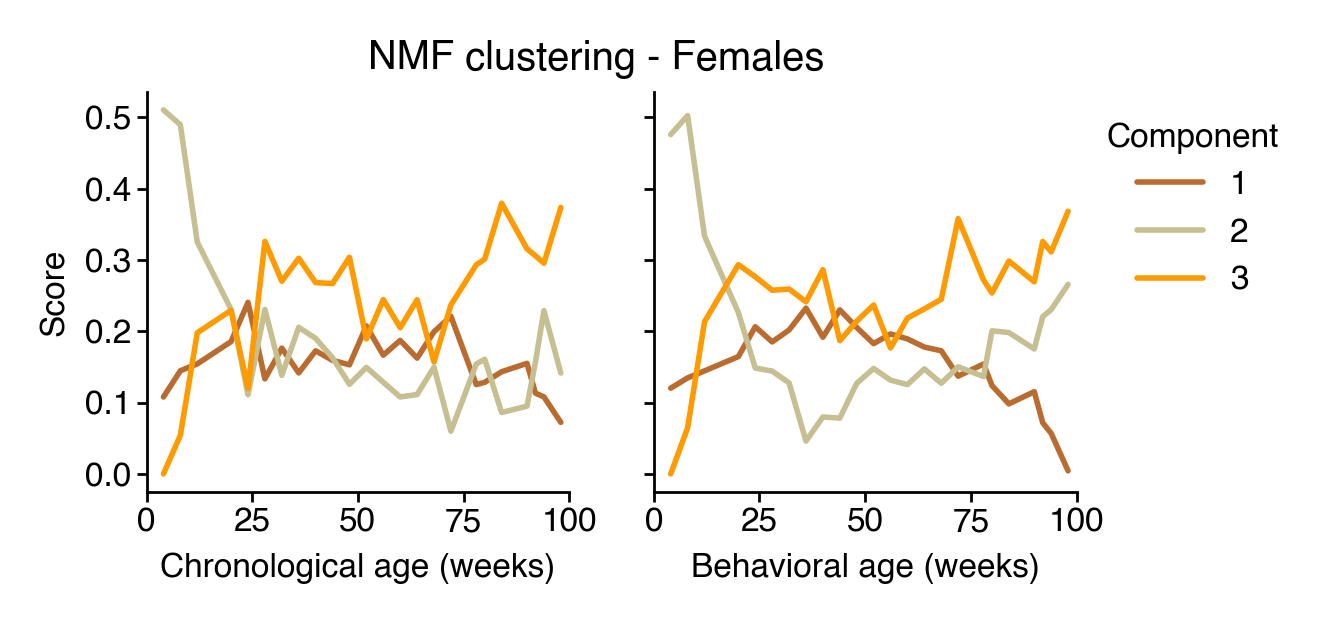

In [72]:
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey_warm[11:])}):
    fig, ax = plt.subplots(1, 2, figsize=(3, 1.3), sharey=True, sharex=True)
    a = chron_avg.plot(ax=ax[0], legend=False)
    a.set(xlabel="Chronological age (weeks)", ylabel="Score")
    a2 = bio_avg.plot(ax=ax[1])
    legend(a2, title="Component")
    a2.set(xlabel="Behavioral age (weeks)", ylabel="Score", xlim=(0, 100))
    sns.despine()
    fig.suptitle("NMF clustering - Females")
    saver(fig, "female-nmf-components-pre-post-sorting-blue-colors");

## K-means

### males

#### sort by chron age

In [73]:
from itertools import combinations
from toolz import groupby, valmap, compose
from toolz.curried import get, pluck

from sklearn.cluster import k_means
from sklearn.metrics import silhouette_score

In [74]:
class_df = pd.read_csv(
    "../v11_syllable_labels_v2.csv", index_col="Original ID", usecols=range(4)
)

def get_class(syll):
    return class_df.loc[syll, "Class"]

In [75]:
mask = df.index.get_level_values('sex') == 0

In [76]:
silhouettes = []

_males = df.loc[mask].copy()
for c, seed in tqdm(product(range(2, 7), range(500))):
    mm_df = minmax(_males.sample(frac=1, replace=True, random_state=seed).groupby('age').mean())
    centroid, labels, inertia = k_means(mm_df.T, c, random_state=seed)
    silhouettes.append(dict(n_clust=c, seed=seed, s_sc=silhouette_score(mm_df.T, labels), sse=inertia))
silhouettes = pd.DataFrame(silhouettes)

0it [00:00, ?it/s]

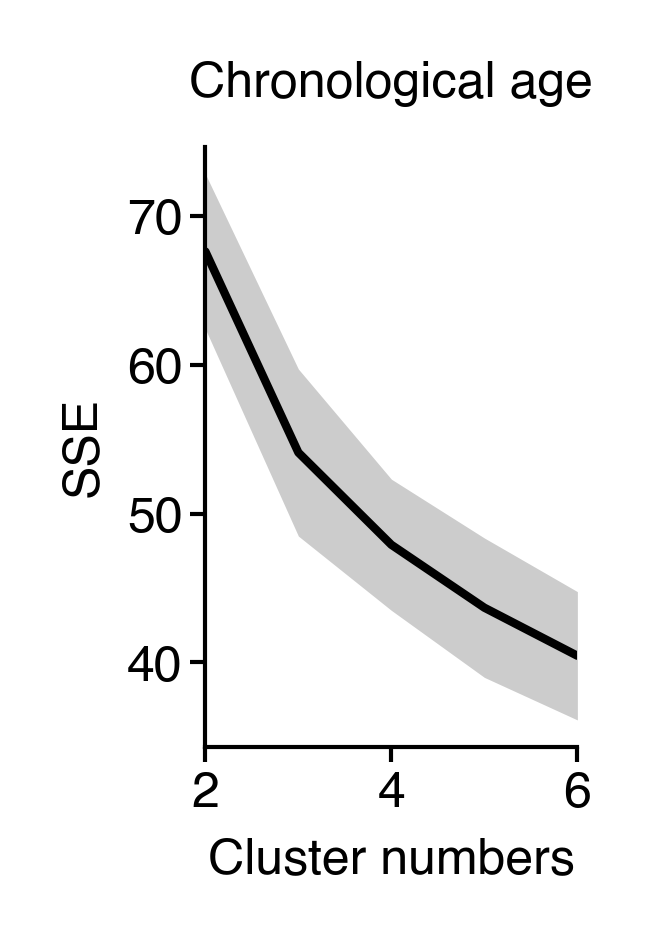

In [77]:
fig = figure(0.8, 1.3)
ax = sns.lineplot(
    data=silhouettes,
    x="n_clust",
    y="sse",
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
    color="k",
)
ax.set(ylabel="SSE", xlabel="Cluster numbers", xlim=(2, 6), title="Chronological age")
sns.despine()
saver(fig, "male-k-means-cluster-silhouette-score-chron-age");

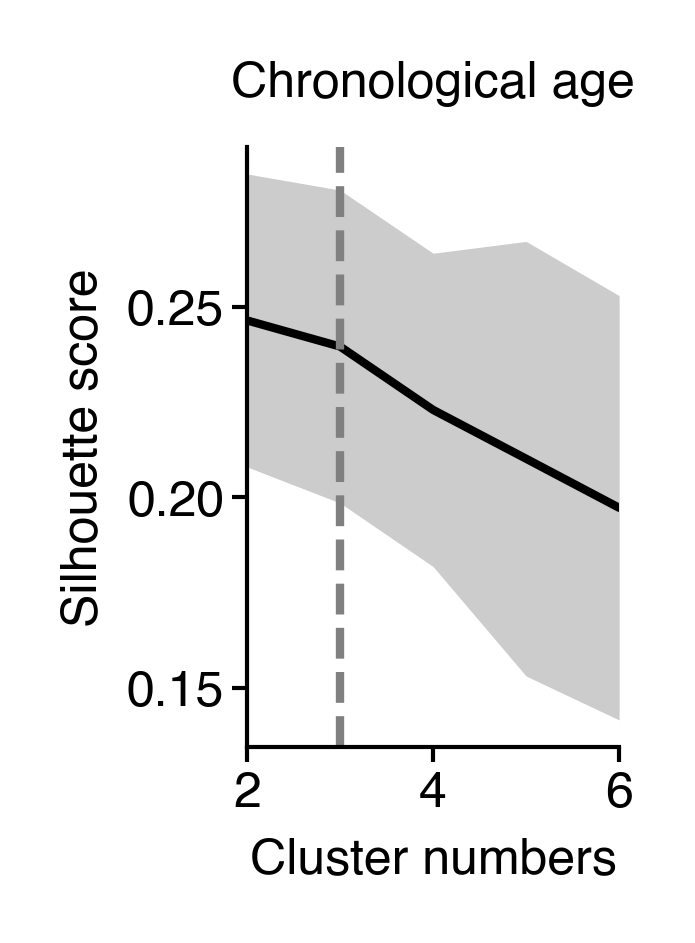

In [78]:
fig = figure(0.8, 1.3)
ax = sns.lineplot(
    data=silhouettes,
    x="n_clust",
    y="s_sc",
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
    color="k",
)
ax.axvline(3, color="gray", ls="--")
ax.set(ylabel="Silhouette score", xlabel="Cluster numbers", xlim=(2, 6), title="Chronological age")
sns.despine()
saver(fig, "male-k-means-cluster-silhouette-score-chron-age");

In [79]:
_males = df.loc[mask].copy()
mm_df = minmax(_males.groupby('age').mean())

n_clust = 4

centroid_dfs = []
syllable_groups = {}

for seed in tqdm(range(5_000)):
    centroid, labels, inertia = k_means(mm_df.T, n_clust, random_state=seed)
    s_sc = silhouette_score(mm_df.T, labels)

    k = pd.DataFrame(centroid.T, index=mm_df.index)
    k['seed'] = seed
    k['s_sc'] = s_sc
    centroid_dfs.append(k)

    groups = groupby(get(0), zip(labels, mm_df.columns))
    groups = valmap(compose(list, pluck(1)), groups)
    syllable_groups[seed] = groups

  0%|          | 0/5000 [00:00<?, ?it/s]

In [80]:
best_kmeans = max(centroid_dfs, key=lambda x: x['s_sc'].max())
best_seed = best_kmeans['seed'].iloc[0]

In [81]:
best_kmeans.head(2)

0         1         2             3  seed      s_sc
age                                                            
4.0  0.225431  0.781202  0.157428  5.551115e-17     3  0.273072
8.0  0.260782  0.855582  0.664584  3.441035e-01     3  0.273072

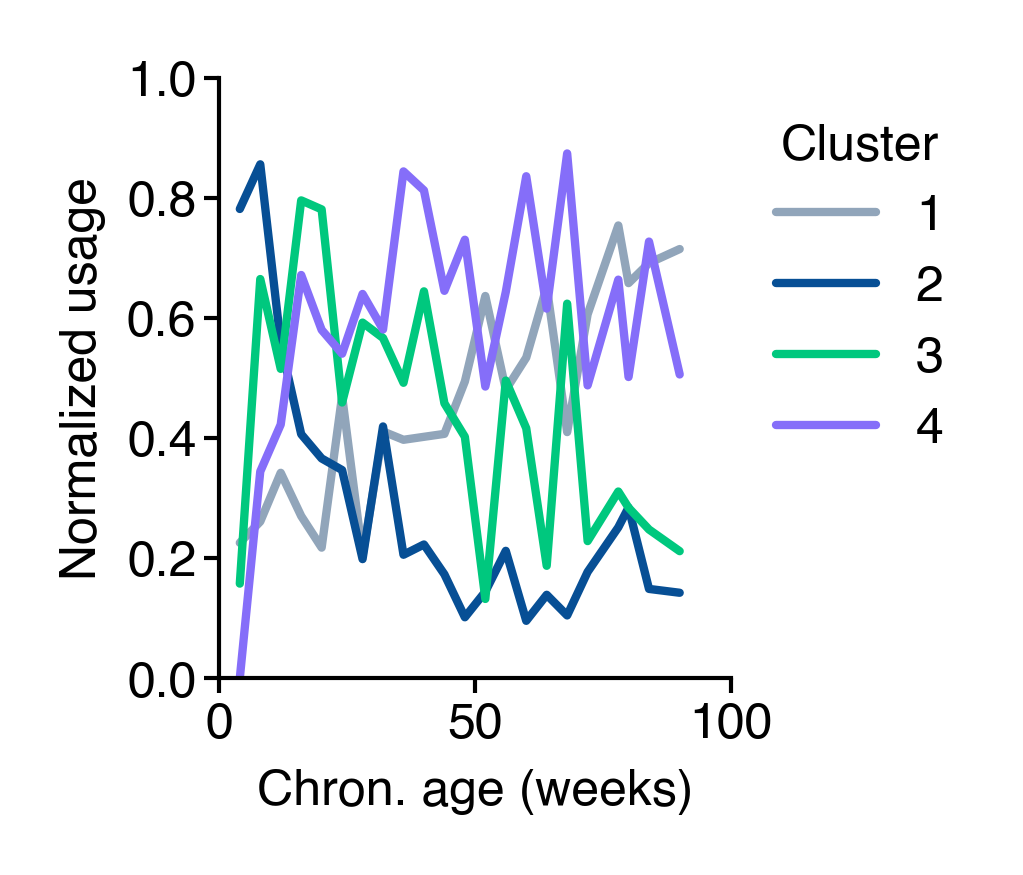

In [82]:
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey_cool[15:])}):
    fig = figure(1.1, 1.3)
    ax = fig.gca()
    ax = best_kmeans.drop(columns=['seed', 's_sc']).rename(columns=lambda x: x + 1).plot(ax=ax)
    legend(ax, title="Cluster")
    ax.set(xlabel="Chron. age (weeks)", ylabel="Normalized usage", xlim=(0, 100), ylim=(0, 1))
    sns.despine()
    saver(fig, "male-k-means-cluster-chron-age");

#### Cluster version with 4 plots, one for each cluster

In [83]:
syll_classes = valmap(lambda x: list(map(get_class, x)), syllable_groups[best_seed])
# sort classes
syll_classes = dict(sorted(syll_classes.items(), key=get(0)))

class_freqs = valmap(lambda x: pd.Series(x).value_counts(), syll_classes)

/n/scratch/users/w/wg41/aging-code/aging/plotting.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


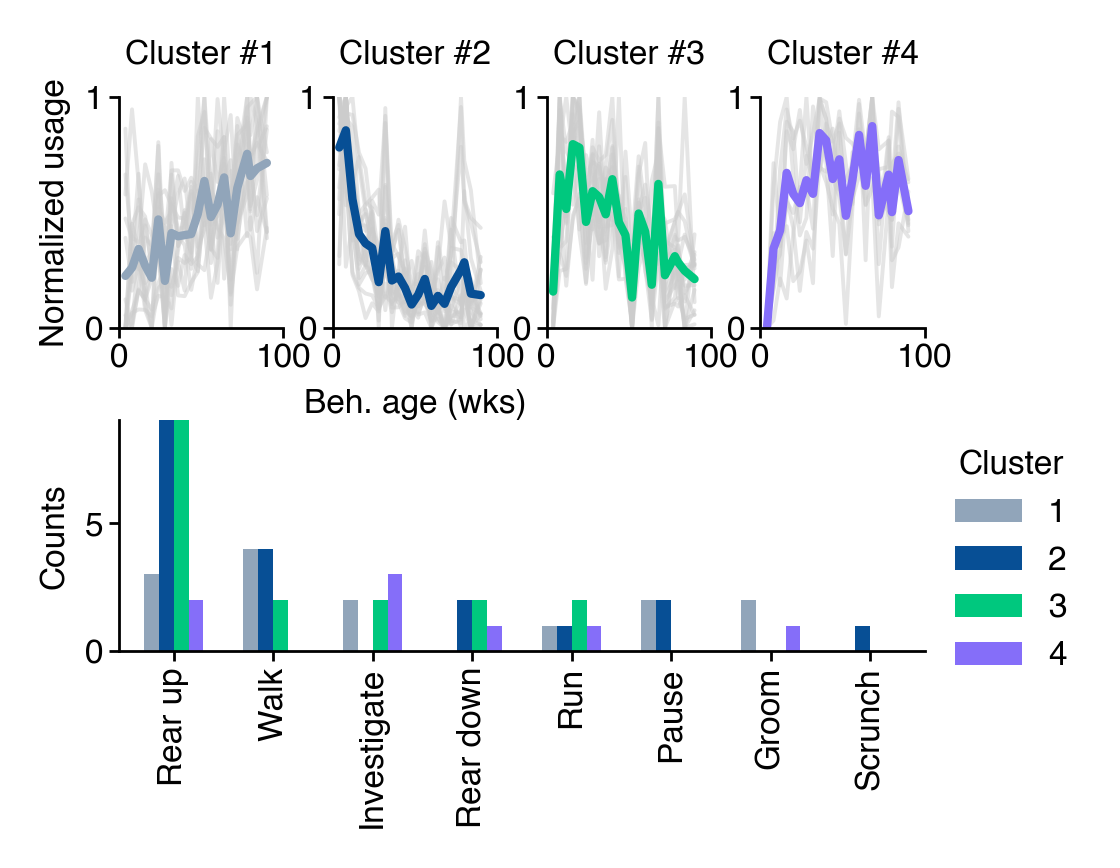

In [84]:
_classes = dict(sorted(syllable_groups[best_seed].items(), key=lambda item: item[0]))

start_letter = ord('a')

row1 = ''.join(chr(start_letter + i) for i in range(n_clust))
row2 = chr(start_letter + n_clust) * n_clust

mosaic = '\n'.join([row1, row2])

fig, ax = plt.subplot_mosaic(mosaic, figsize=(2.6, 1.8), gridspec_kw={'wspace': 0.3, 'hspace': 0.4})

for _a, ((k, sylls), color) in enumerate(zip(_classes.items(), cc.glasbey_cool[15:])):
    letter = chr(_a + 97)
    a = ax[letter]
    mm_df[sylls].plot(ax=a, legend=False, color='#ccc', alpha=0.5, lw=0.7)
    a.plot(mm_df[sylls].mean(1), color=color, lw=1.5)
    a.set(title=f"Cluster #{k + 1}", xlabel="", ylim=(0, 1), yticks=(0, 1), xlim=(0, 100))
ax['a'].set(ylabel="Normalized usage")
ax['b'].set(xlabel="Beh. age (wks)")

with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey_cool[15:])}):
    a = ax[chr(start_letter + n_clust)]
    cf_df = pd.DataFrame(class_freqs).fillna(0).rename(columns=lambda x: x+1)
    cf_df = cf_df.loc[cf_df.sum(1).sort_values(ascending=False).index]
    a = cf_df.plot(kind='bar', ax=a, width=0.6, linewidth=0)
    legend(a, title="Cluster")
    a.set(ylabel="Counts", xlabel="", ylim=(0, cf_df.max().max()))
sns.despine()
saver(fig, "male-k-means-cluster-all-sylls-chron-age", tight_layout=True);

In [85]:
joblib.dump(syllable_groups[best_seed], '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/male-kmeans-label-dict-chron-age.p')

['/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/male-kmeans-label-dict-chron-age.p']

#### Sort by bio age

In [86]:
silhouettes = []

_males = df.loc[mask].copy()
_males['bio_age'] = mdl['bio_ages'][mask]
_age = _males.index.get_level_values('age')
_males = _males.sort_values(by='bio_age')
_males['bio_age_map'] = _age.to_numpy()
_males = _males.loc[df.index[mask]].drop(columns=['bio_age']).set_index('bio_age_map', append=True)

for c, seed in tqdm(product(range(2, 7), range(500))):
    mm_df = minmax(_males.sample(frac=1, replace=True, random_state=seed).groupby('bio_age_map').mean())
    pd_mtx = squareform(pdist(mm_df.T, metric='correlation'))

    cols = mm_df.columns.to_numpy()
    col_map = dict(map(reversed, enumerate(cols)))

    def to_syll_array(sylls):
        return np.array([col_map[s] for s in sylls])

    centroid, labels, inertia = k_means(mm_df.T, c, random_state=seed)

    groups = groupby(get(0), zip(labels, mm_df.columns))
    groups = valmap(compose(list, pluck(1)), groups)

    silhouettes.append(dict(n_clust=c, seed=seed, s_sc=silhouette_score(mm_df.T, labels), sse=inertia))
silhouettes = pd.DataFrame(silhouettes)

0it [00:00, ?it/s]

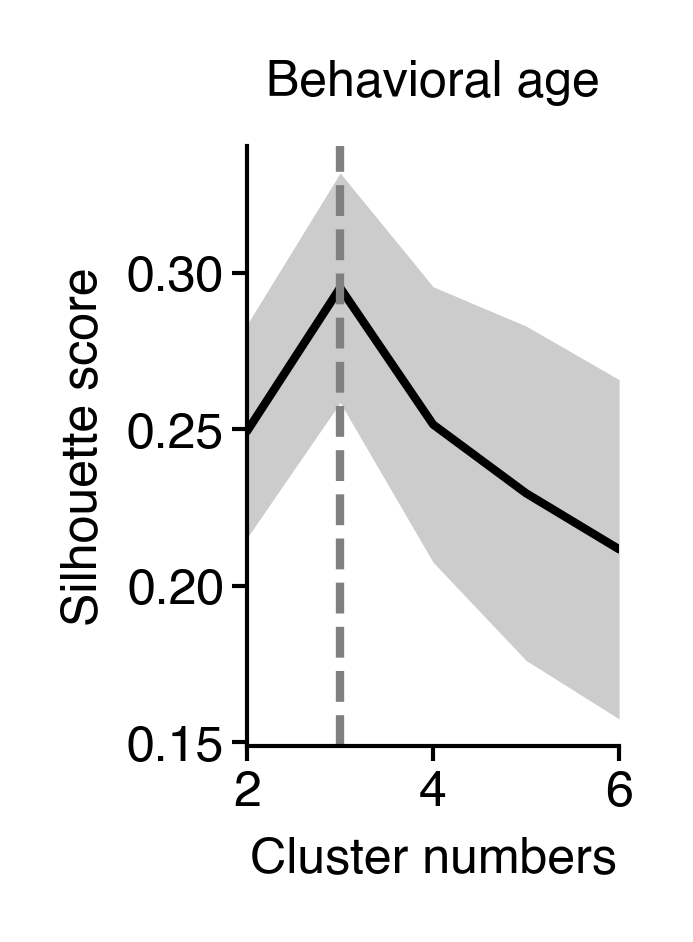

In [87]:
fig = figure(0.8, 1.3)
ax = sns.lineplot(
    data=silhouettes,
    x="n_clust",
    y="s_sc",
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
    color="k",
)
ax.axvline(3, color="gray", ls="--")
ax.set(ylabel="Silhouette score", xlabel="Cluster numbers", xlim=(2, 6), title="Behavioral age")
sns.despine()
saver(fig, "male-k-means-cluster-silhouette-score-beh-age");

In [88]:
_males = df.loc[mask].copy()
_males['bio_age'] = mdl['bio_ages'][mask]
_age = _males.index.get_level_values('age')
_males = _males.sort_values(by='bio_age')
_males['bio_age_map'] = _age.to_numpy()
_males = _males.loc[df.index[mask]].drop(columns=['bio_age']).set_index('bio_age_map', append=True)

mm_df = minmax(_males.groupby('bio_age_map').mean())

centroid_dfs = []
syllable_groups = {}

for seed in tqdm(range(5_000)):
    centroid, labels, inertia = k_means(mm_df.T, n_clust, random_state=seed)
    s_sc = silhouette_score(mm_df.T, labels)

    k = pd.DataFrame(centroid.T, index=mm_df.index)
    k['seed'] = seed
    k['s_sc'] = s_sc

    groups = groupby(get(0), zip(labels, mm_df.columns))
    groups = valmap(compose(list, pluck(1)), groups)
    syllable_groups[seed] = groups

    centroid_dfs.append(k)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [89]:
best_kmeans = max(centroid_dfs, key=lambda x: x['s_sc'].max())
best_seed = best_kmeans['seed'].iloc[0]

In [90]:
best_kmeans.head(2)

0         1         2         3  seed      s_sc
bio_age_map                                                        
4.0          0.808909  0.210241  0.217337  0.128028   275  0.317595
8.0          0.834963  0.548582  0.285078  0.146315   275  0.317595

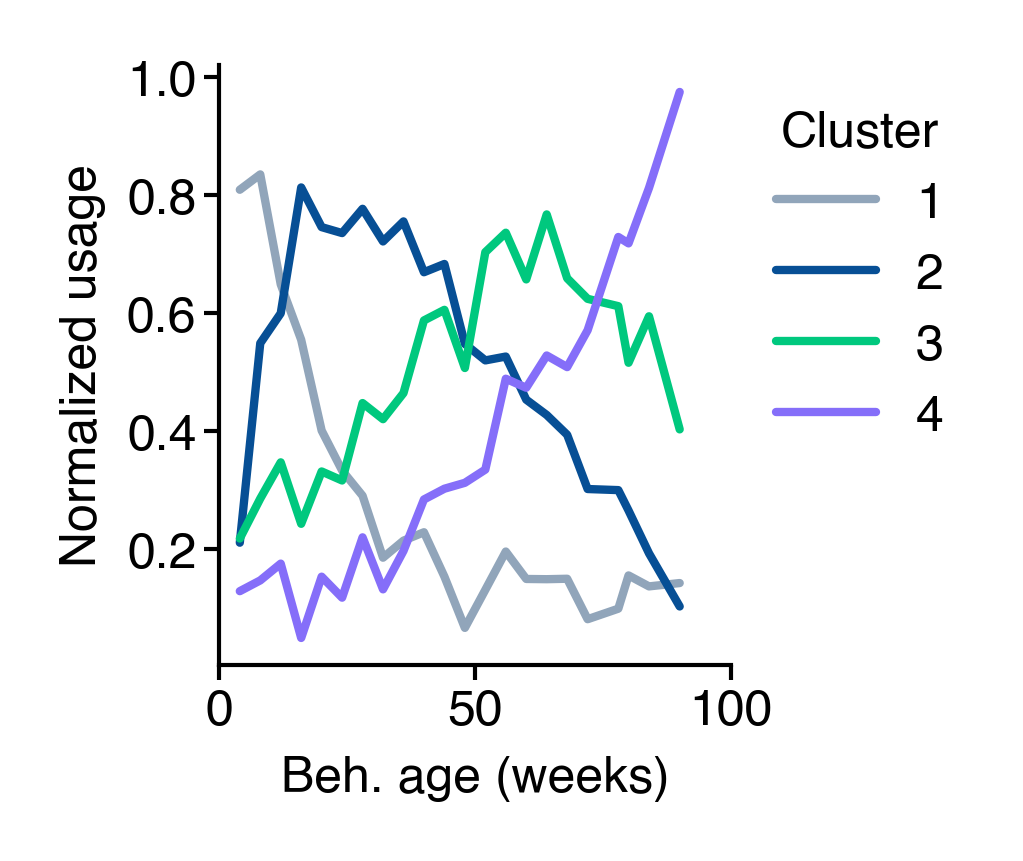

In [91]:
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey_cool[15:])}):
    fig = figure(1.1, 1.3)
    ax = fig.gca()
    ax = best_kmeans.drop(columns=['seed', 's_sc']).rename(columns=lambda x: x + 1).plot(ax=ax)
    legend(ax, title="Cluster")
    ax.set(xlabel="Beh. age (weeks)", ylabel="Normalized usage", xlim=(0, 100))
    sns.despine()
    saver(fig, "male-k-means-cluster-beh-age");

In [92]:
syll_classes = valmap(lambda x: list(map(get_class, x)), syllable_groups[best_seed])
# sort classes
syll_classes = dict(sorted(syll_classes.items(), key=get(0)))

class_freqs = valmap(lambda x: pd.Series(x).value_counts(), syll_classes)

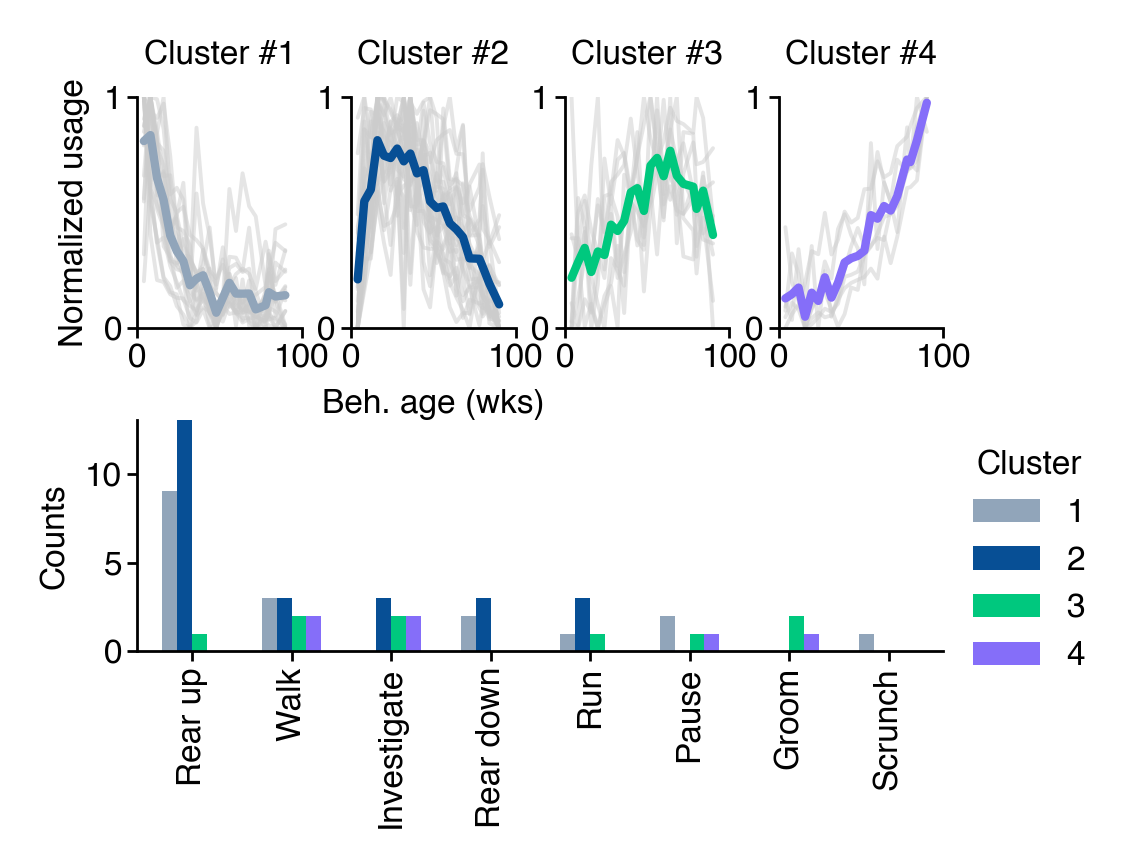

In [93]:
_classes = dict(sorted(syllable_groups[best_seed].items(), key=lambda item: item[0]))

start_letter = ord('a')

row1 = ''.join(chr(start_letter + i) for i in range(n_clust))
row2 = chr(start_letter + n_clust) * n_clust

mosaic = '\n'.join([row1, row2])

fig, ax = plt.subplot_mosaic(mosaic, figsize=(2.6, 1.8), gridspec_kw={'wspace': 0.3, 'hspace': 0.4})

for _a, ((k, sylls), color) in enumerate(zip(_classes.items(), cc.glasbey_cool[15:])):
    letter = chr(_a + 97)
    a = ax[letter]
    mm_df[sylls].plot(ax=a, legend=False, color='#ccc', alpha=0.5, lw=0.7)
    a.plot(mm_df[sylls].mean(1), color=color, lw=1.5)
    a.set(title=f"Cluster #{k + 1}", xlabel="", ylim=(0, 1), yticks=(0, 1), xlim=(0, 100))
ax['a'].set(ylabel="Normalized usage")
ax['b'].set(xlabel="Beh. age (wks)")

with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey_cool[15:])}):
    a = ax[chr(start_letter + n_clust)]
    cf_df = pd.DataFrame(class_freqs).fillna(0).rename(columns=lambda x: x+1)
    cf_df = cf_df.loc[cf_df.sum(1).sort_values(ascending=False).index]
    a = cf_df.plot(kind='bar', ax=a, width=0.6, linewidth=0)
    legend(a, title="Cluster")
    a.set(ylabel="Counts", xlabel="", ylim=(0, cf_df.max().max()))
sns.despine()
saver(fig, "male-k-means-cluster-all-sylls-beh-age", tight_layout=False);

In [94]:
joblib.dump(syllable_groups[best_seed], '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/male-kmeans-label-dict-beh-age.p')

['/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/male-kmeans-label-dict-beh-age.p']

### females

In [95]:
mask = df.index.get_level_values('sex') == 1

In [96]:
silhouettes = []

_males = df.loc[mask].copy()
for c, seed in tqdm(product(range(2, 7), range(500))):
    mm_df = minmax(_males.sample(frac=1, replace=True, random_state=seed).groupby('age').mean())
    centroid, labels, inertia = k_means(mm_df.T, c, random_state=seed)
    silhouettes.append(dict(n_clust=c, seed=seed, s_sc=silhouette_score(mm_df.T, labels), sse=inertia))
silhouettes = pd.DataFrame(silhouettes)

0it [00:00, ?it/s]

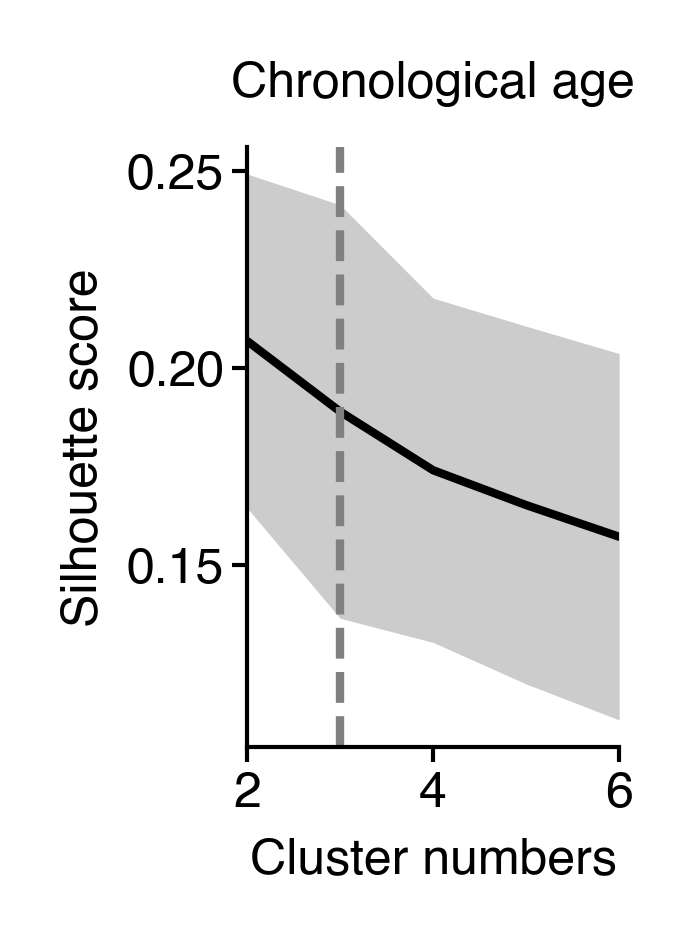

In [97]:
fig = figure(0.8, 1.3)
ax = sns.lineplot(
    data=silhouettes,
    x="n_clust",
    y="s_sc",
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
    color="k",
)
ax.axvline(3, color="gray", ls="--")
ax.set(ylabel="Silhouette score", xlabel="Cluster numbers", xlim=(2, 6), title="Chronological age")
sns.despine()
saver(fig, "female-k-means-cluster-silhouette-score-chron-age");

In [98]:
_males = df.loc[mask].copy()
mm_df = minmax(_males.groupby('age').mean())

centroid_dfs = []
syllable_groups = {}

for seed in tqdm(range(5_000)):
    centroid, labels, inertia = k_means(mm_df.T, n_clust, random_state=seed)
    s_sc = silhouette_score(mm_df.T, labels)

    k = pd.DataFrame(centroid.T, index=mm_df.index)
    k['seed'] = seed
    k['s_sc'] = s_sc
    centroid_dfs.append(k)

    groups = groupby(get(0), zip(labels, mm_df.columns))
    groups = valmap(compose(list, pluck(1)), groups)
    syllable_groups[seed] = groups

  0%|          | 0/5000 [00:00<?, ?it/s]

In [99]:
best_kmeans = max(centroid_dfs, key=lambda x: x['s_sc'].max())
best_seed = best_kmeans['seed'].iloc[0]

In [100]:
best_kmeans.head(2)

0         1         2         3  seed      s_sc
age                                                        
4.0  0.170455  0.683069  0.013151  0.523677   256  0.245205
8.0  0.157173  0.760724  0.283560  0.509546   256  0.245205

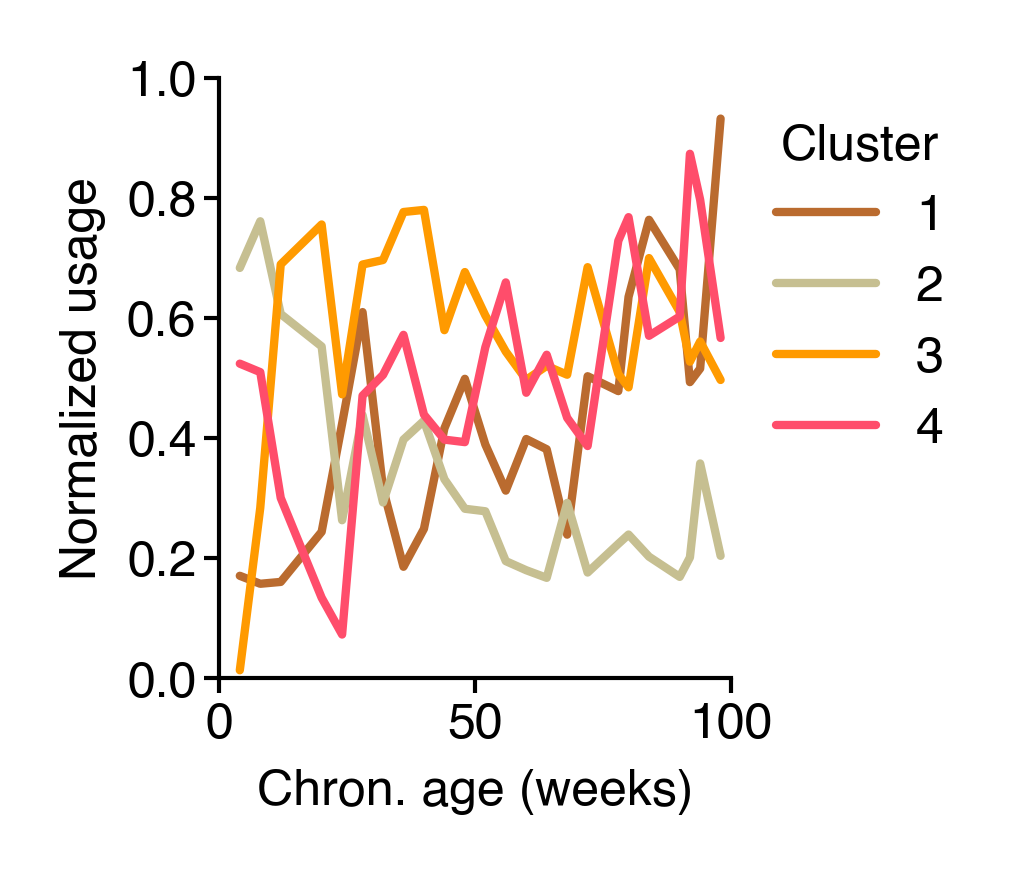

In [101]:
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey_warm[11:])}):
    fig = figure(1.1, 1.3)
    ax = fig.gca()
    ax = best_kmeans.drop(columns=['seed', 's_sc']).rename(columns=lambda x: x + 1).plot(ax=ax)
    legend(ax, title="Cluster")
    ax.set(xlabel="Chron. age (weeks)", ylabel="Normalized usage", xlim=(0, 100), ylim=(0, 1))
    sns.despine()
    saver(fig, "female-k-means-cluster-chron-age");

In [102]:
syll_classes = valmap(lambda x: list(map(get_class, x)), syllable_groups[best_seed])
# sort classes
syll_classes = dict(sorted(syll_classes.items(), key=get(0)))

class_freqs = valmap(lambda x: pd.Series(x).value_counts(), syll_classes)

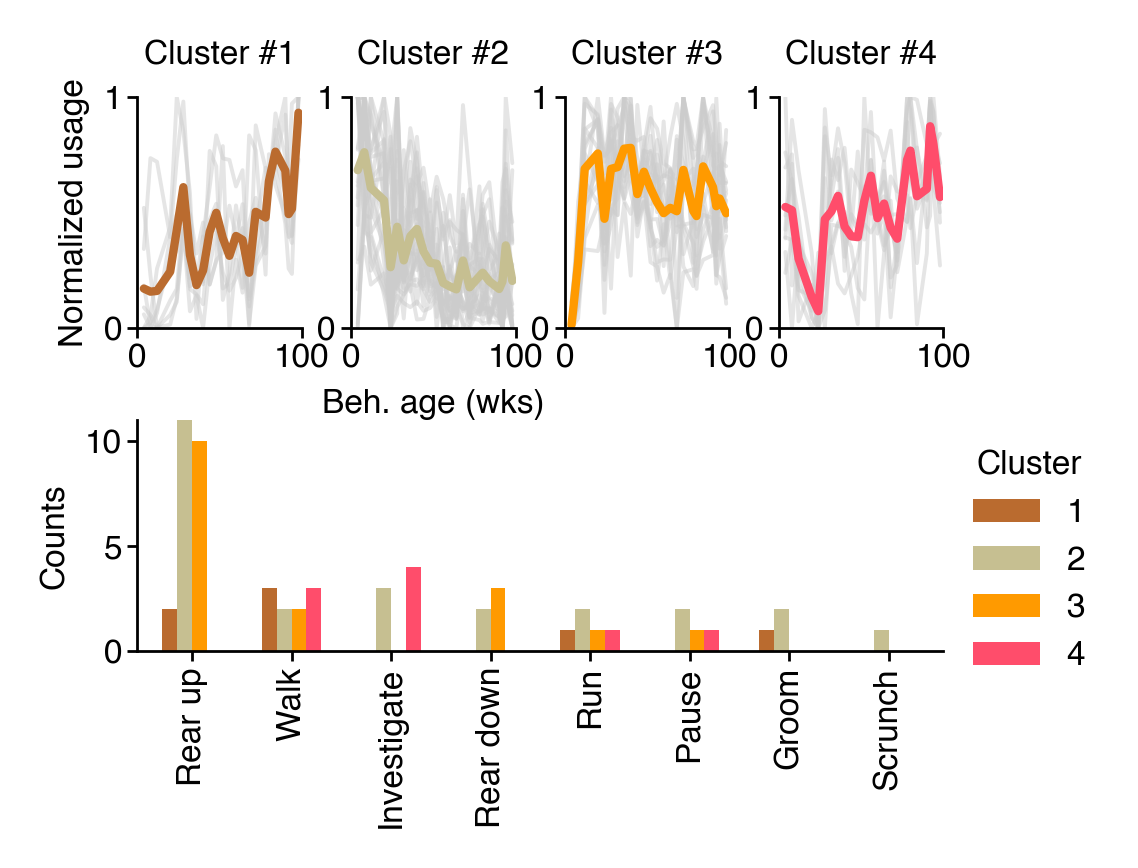

In [103]:
_classes = dict(sorted(syllable_groups[best_seed].items(), key=lambda item: item[0]))

start_letter = ord('a')

row1 = ''.join(chr(start_letter + i) for i in range(n_clust))
row2 = chr(start_letter + n_clust) * n_clust

mosaic = '\n'.join([row1, row2])

fig, ax = plt.subplot_mosaic(mosaic, figsize=(2.6, 1.8), gridspec_kw={'wspace': 0.3, 'hspace': 0.4})

for _a, ((k, sylls), color) in enumerate(zip(_classes.items(), cc.glasbey_warm[11:])):
    letter = chr(_a + 97)
    a = ax[letter]
    mm_df[sylls].plot(ax=a, legend=False, color='#ccc', alpha=0.5, lw=0.7)
    a.plot(mm_df[sylls].mean(1), color=color, lw=1.5)
    a.set(title=f"Cluster #{k + 1}", xlabel="", ylim=(0, 1), yticks=(0, 1), xlim=(0, 100))
ax['a'].set(ylabel="Normalized usage")
ax['b'].set(xlabel="Beh. age (wks)")

with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey_warm[11:])}):
    a = ax[chr(start_letter + n_clust)]
    cf_df = pd.DataFrame(class_freqs).fillna(0).rename(columns=lambda x: x+1)
    cf_df = cf_df.loc[cf_df.sum(1).sort_values(ascending=False).index]
    a = cf_df.plot(kind='bar', ax=a, width=0.6, linewidth=0)
    legend(a, title="Cluster")
    a.set(ylabel="Counts", xlabel="", ylim=(0, cf_df.max().max()))
sns.despine()
saver(fig, "female-k-means-cluster-all-sylls-chron-age", tight_layout=False);

In [104]:
joblib.dump(syllable_groups[best_seed], '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/female-kmeans-label-dict-chron-age.p')

['/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/female-kmeans-label-dict-chron-age.p']

#### Sort by bio age

In [105]:
silhouettes = []

_males = df.loc[mask].copy()
_males['bio_age'] = mdl['bio_ages'][mask]
_age = _males.index.get_level_values('age')
_males = _males.sort_values(by='bio_age')
_males['bio_age_map'] = _age.to_numpy()
_males = _males.loc[df.index[mask]].drop(columns=['bio_age']).set_index('bio_age_map', append=True)

for c, seed in tqdm(product(range(2, 7), range(500))):
    mm_df = minmax(_males.sample(frac=1, replace=True, random_state=seed).groupby('bio_age_map').mean())
    centroid, labels, inertia = k_means(mm_df.T, c, random_state=seed)
    silhouettes.append(dict(n_clust=c, seed=seed, s_sc=silhouette_score(mm_df.T, labels), sse=inertia))
silhouettes = pd.DataFrame(silhouettes)

0it [00:00, ?it/s]

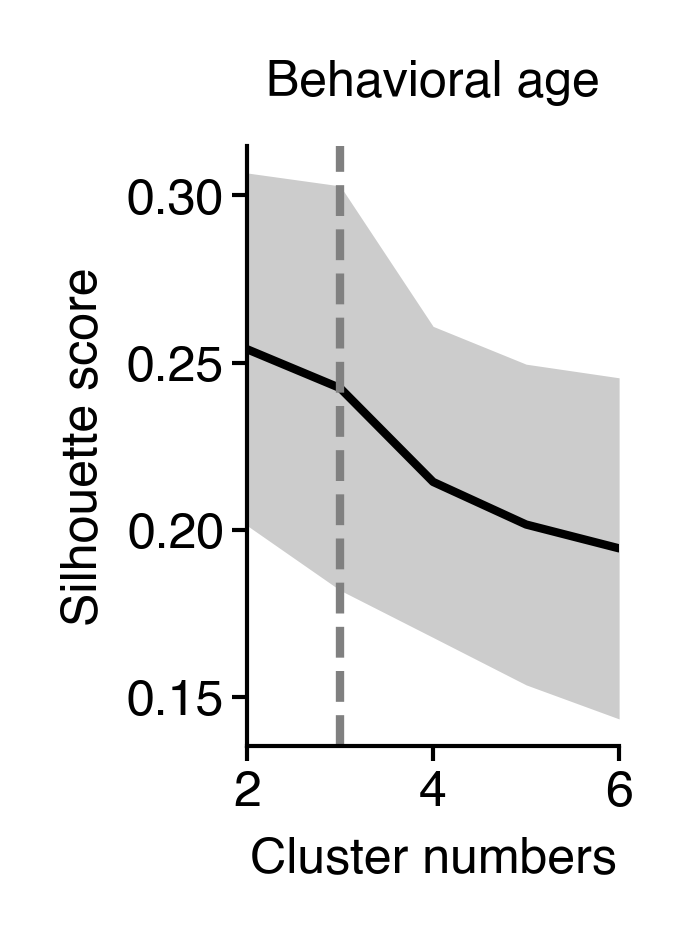

In [106]:
fig = figure(0.8, 1.3)
ax = sns.lineplot(
    data=silhouettes,
    x="n_clust",
    y="s_sc",
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
    color="k",
)
ax.axvline(3, color="gray", ls="--")
ax.set(ylabel="Silhouette score", xlabel="Cluster numbers", xlim=(2, 6), title="Behavioral age")
sns.despine()
saver(fig, "female-k-means-cluster-silhouette-score-beh-age");

In [107]:
_males = df.loc[mask].copy()
_males['bio_age'] = mdl['bio_ages'][mask]
_age = _males.index.get_level_values('age')
_males = _males.sort_values(by='bio_age')
_males['bio_age_map'] = _age.to_numpy()
_males = _males.loc[df.index[mask]].drop(columns=['bio_age']).set_index('bio_age_map', append=True)

mm_df = minmax(_males.groupby('bio_age_map').mean())

centroid_dfs = []
syllable_groups = {}

for seed in tqdm(range(5_000)):
    centroid, labels, inertia = k_means(mm_df.T, n_clust, random_state=seed)
    s_sc = silhouette_score(mm_df.T, labels)

    k = pd.DataFrame(centroid.T, index=mm_df.index)
    k['seed'] = seed
    k['s_sc'] = s_sc
    centroid_dfs.append(k)

    groups = groupby(get(0), zip(labels, mm_df.columns))
    groups = valmap(compose(list, pluck(1)), groups)
    syllable_groups[seed] = groups

  0%|          | 0/5000 [00:00<?, ?it/s]

In [108]:
best_kmeans = max(centroid_dfs, key=lambda x: x['s_sc'].max())
best_seed = best_kmeans['seed'].iloc[0]

In [109]:
best_kmeans.head(2)

0         1         2         3  seed     s_sc
bio_age_map                                                       
4.0          0.677500  0.542875  0.147628  0.377632   528  0.31073
8.0          0.855684  0.772218  0.348271  0.312694   528  0.31073

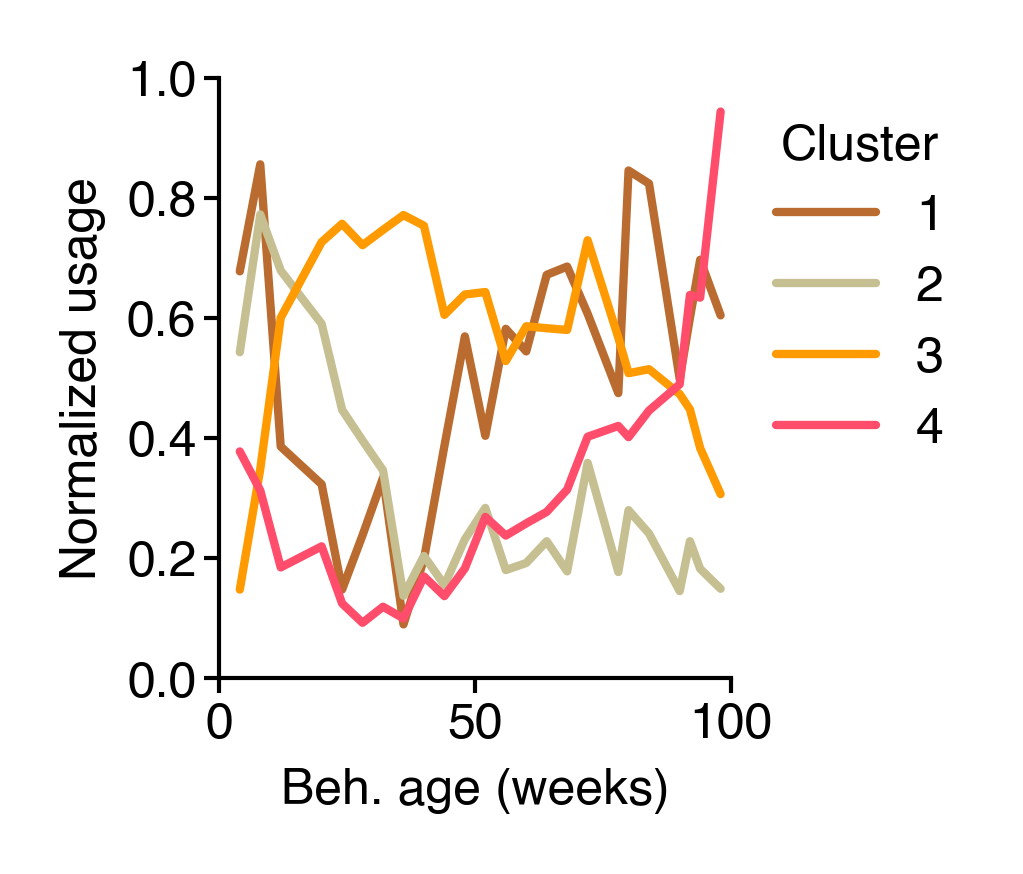

In [110]:
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey_warm[11:])}):
    fig = figure(1.1, 1.3)
    ax = fig.gca()
    ax = best_kmeans.drop(columns=['seed', 's_sc']).rename(columns=lambda x: x + 1).plot(ax=ax)
    legend(ax, title="Cluster")
    ax.set(xlabel="Beh. age (weeks)", ylabel="Normalized usage", xlim=(0, 100), ylim=(0, 1))
    sns.despine()
    saver(fig, "female-k-means-cluster-beh-age");

In [111]:
syll_classes = valmap(lambda x: list(map(get_class, x)), syllable_groups[best_seed])
# sort classes
syll_classes = dict(sorted(syll_classes.items(), key=get(0)))

class_freqs = valmap(lambda x: pd.Series(x).value_counts(), syll_classes)

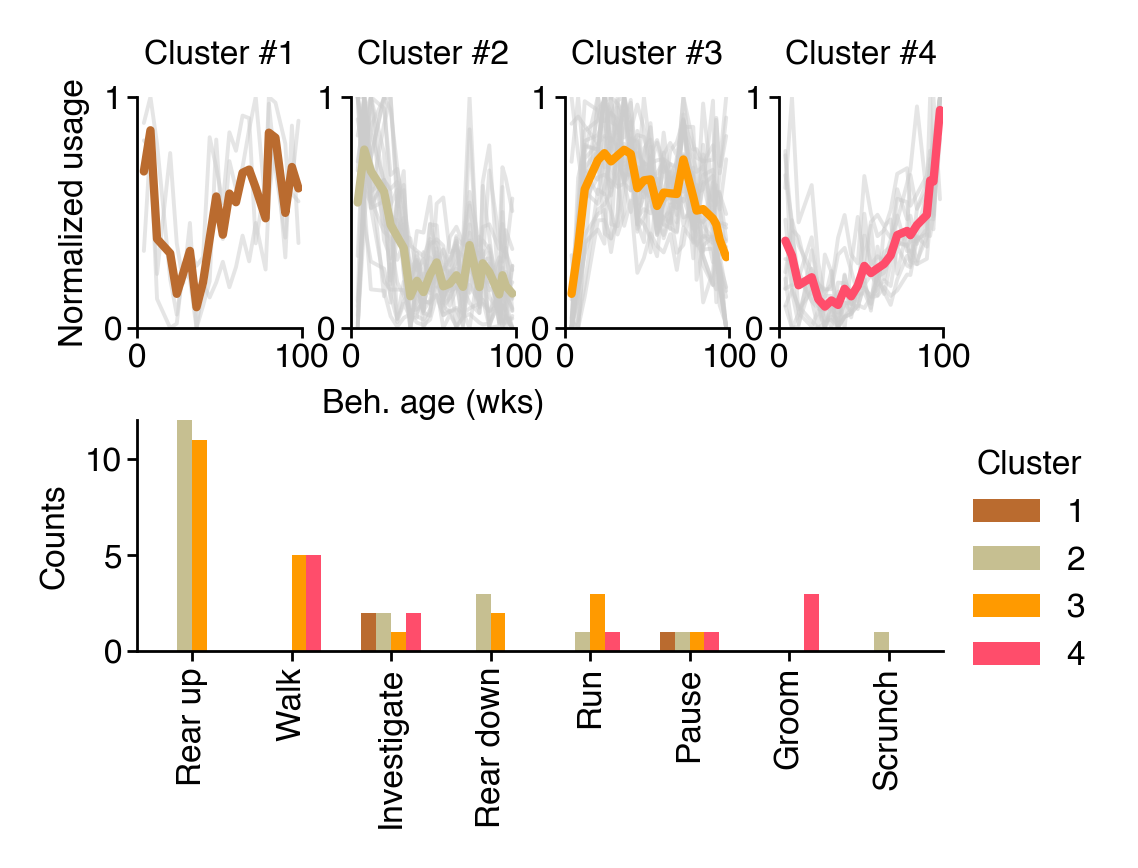

In [112]:
_classes = dict(sorted(syllable_groups[best_seed].items(), key=lambda item: item[0]))

start_letter = ord('a')

row1 = ''.join(chr(start_letter + i) for i in range(n_clust))
row2 = chr(start_letter + n_clust) * n_clust

mosaic = '\n'.join([row1, row2])

fig, ax = plt.subplot_mosaic(mosaic, figsize=(2.6, 1.8), gridspec_kw={'wspace': 0.3, 'hspace': 0.4})

for _a, ((k, sylls), color) in enumerate(zip(_classes.items(), cc.glasbey_warm[11:])):
    letter = chr(_a + 97)
    a = ax[letter]
    mm_df[sylls].plot(ax=a, legend=False, color='#ccc', alpha=0.5, lw=0.7)
    a.plot(mm_df[sylls].mean(1), color=color, lw=1.5)
    a.set(title=f"Cluster #{k + 1}", xlabel="", ylim=(0, 1), yticks=(0, 1), xlim=(0, 100))
ax['a'].set(ylabel="Normalized usage")
ax['b'].set(xlabel="Beh. age (wks)")

with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey_warm[11:])}):
    a = ax[chr(start_letter + n_clust)]
    cf_df = pd.DataFrame(class_freqs).fillna(0).rename(columns=lambda x: x+1)
    cf_df = cf_df.loc[cf_df.sum(1).sort_values(ascending=False).index]
    a = cf_df.plot(kind='bar', ax=a, width=0.6, linewidth=0)
    legend(a, title="Cluster")
    a.set(ylabel="Counts", xlabel="", ylim=(0, cf_df.max().max()))
sns.despine()
saver(fig, "female-k-means-cluster-all-sylls-beh-age", tight_layout=False);

In [113]:
joblib.dump(syllable_groups[best_seed], '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/female-kmeans-label-dict-beh-age.p')

['/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/female-kmeans-label-dict-beh-age.p']

## Show shuffles/controls

In [114]:
from scipy.stats import ttest_ind

In [115]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": pd.concat([sizes_col, female_sizes_col]).to_numpy(),  # models > 1
    "mice": sex_id,
}

age_sd = 0.04

hypparams = {
    "log_age": True,
    "min_age": 3,
    "max_age": 130,
    "age_sd": age_sd,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "scale": 400,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(sex_id),
    "lr": 0.25,
    "n_opt_iter": 1300,
}

In [116]:
n_repeats = 25

In [ ]:
hyp_copy = deepcopy(hypparams)
mdl3 = masked_xval(features, hyp_copy, 5, n_repeats=n_repeats)
r2_3 = list(pluck('heldout_r2_total_v3', mdl3.values()))
ll_3 = list(pluck('heldout_ll', mdl3.values()))
print(np.mean(r2_3))
del mdl3

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
hyp_copy = deepcopy(hypparams)
mdl2 = masked_xval(features, hyp_copy, 2, n_repeats=n_repeats)
r2_2 = list(pluck('heldout_r2_total_v3', mdl2.values()))
ll_2 = list(pluck('heldout_ll', mdl2.values()))
print(np.mean(r2_2))
del mdl2

In [ ]:
ttest_ind(r2_2, r2_3, alternative='less')

In [ ]:
ttest_ind(ll_2, ll_3, alternative='less')

In [ ]:
hyp_copy = deepcopy(hypparams)
mdl1 = masked_xval(features, hyp_copy, 1, n_repeats=n_repeats)
r2_1 = list(pluck('heldout_r2_total_v3', mdl1.values()))
ll_1 = list(pluck('heldout_ll', mdl1.values()))
print(np.mean(r2_1))
del mdl1

In [ ]:
hyp_copy = deepcopy(hypparams)
mdl0 = masked_xval(features, hyp_copy, 0, n_repeats=n_repeats)
r2_0 = list(pluck('heldout_r2_total_v3', mdl0.values()))
ll_0 = list(pluck('heldout_ll', mdl0.values()))
print(np.mean(r2_0))
del mdl0

In [ ]:
hyp_copy = deepcopy(hypparams)
hyp_copy['age_sd'] = 1e-6
mdl0_1 = masked_xval(features, hyp_copy, 1, n_repeats=n_repeats)
r2_0_1 = list(pluck('heldout_r2_total_v3', mdl0_1.values()))
ll_0_1 = list(pluck('heldout_ll', mdl0_1.values()))
print(np.mean(r2_0_1))
del mdl0_1

In [ ]:
# shuffle syllables
np.random.seed(0)
shuff_features = deepcopy(features)
hyp_copy = deepcopy(hypparams)
hyp_copy['n_opt_iter'] = 800

r2_shuff = []
ll_shuff = []
for i in tqdm(range(n_repeats)):
    perm = np.array([np.random.permutation(58) for _ in range(len(syllable_counts_jax))])
    shuff = syllable_counts_jax[np.arange(len(syllable_counts_jax))[:, None], perm]
    shuff_features['counts'] = shuff
    try:
        tmp = masked_xval(shuff_features, hyp_copy, model_version=5, n_repeats=1, seed=i, disable_tqdm=True, return_loss_on_error=True)
        if len(tmp[0]) > 1:
            r2_shuff.append(tmp[0]['heldout_r2_total_v3'])
            ll_shuff.append(tmp[0]['heldout_ll'])
        else:
            print('Non-NaN iterations:', hyp_copy['n_opt_iter'] - np.isnan(tmp[0]['loss']).sum())
        del tmp
    except ValueError:
        continue
print(np.mean(r2_shuff))

In [ ]:
# shuffle sexes
np.random.seed(0)

shuff_features = deepcopy(features)
hyp_copy = deepcopy(hypparams)

shuff_r2s = []
shuff_lls = []
for i in tqdm(range(n_repeats)):
    shuff_features['mice'] = np.random.permutation(features['mice'].T).T
    try:
        shuff_results = masked_xval(shuff_features, hyp_copy, 5, n_repeats=1, seed=i, disable_tqdm=True)
        shuff_r2s.append(shuff_results[0]['heldout_r2_total_v3'])
        shuff_lls.append(shuff_results[0]['heldout_ll'])
    except ValueError:
        continue
print(np.mean(shuff_r2s))

In [ ]:
plt_data = {
    "Syll. shuffle": r2_shuff,
    "Sex shuffle": shuff_r2s,
    "Chron. age": r2_0_1,
    "Linear": r2_0,
    "Beh. age": r2_1,
    "Beh. age + size": r2_2,
    "Beh. age + size + sex": r2_3,
}

fig = figure(1.1, 1.3)
ax = sns.pointplot(
    data=plt_data,
    palette=["silver", "silver", "gray", "gray", "lightgreen", "limegreen", "green"],
    linewidth=0.6, errorbar=('sd', 2), ms=3
)
ax.set(
    xlabel="BAMBI model type",
    ylabel="Heldout R2",
    ylim=(-0.3, 0.7),
)
plt.xticks(rotation=90)
sns.despine()
saver(fig, "ontogeny-males-females-heldout-r2-model-comparison");

In [ ]:
plt_data = {
    "Beh. age": r2_1,
    "Beh. age + size": r2_2,
    "Beh. age + size + sex": r2_3,
}

fig = figure(0.4, 1.3)
ax = sns.pointplot(
    data=plt_data,
    palette=["lightgreen", "limegreen", "green"],
    linewidth=0.6, errorbar=('sd', 2), ms=3
)
ax.set(
    xlabel="BAMBI model type",
    ylabel="Heldout R2",
)
plt.xticks(rotation=90)
sns.despine()
saver(fig, "ontogeny-males-females-heldout-r2-model-comparison-just-bambi");

## Heldout LLs

In [ ]:
all_ll_plot_data = {
    "Syll. shuffle": ll_shuff,
    "Sex shuffle": shuff_lls,
    "Chron. age": ll_0_1,
    "Linear": ll_0,
    "Beh. age": ll_1,
    "Beh. age + size": ll_2,
    "Beh. age + size + sex": ll_3,
}

In [ ]:
plt_data = {
    "Syll. shuffle": ll_shuff,
    "Sex shuffle": shuff_lls,
    "Chron. age": ll_0_1,
    "Linear": ll_0,
    "Beh. age": ll_1,
    "Beh. age + size": ll_2,
    "Beh. age + size + sex": ll_3,
}

fig = figure(1.1, 1.3)
ax = sns.pointplot(
    data=plt_data,
    palette=["silver", "silver", "gray", "gray", "lightgreen", "limegreen", "green"],
    linewidth=0.6, errorbar=('sd', 2), ms=3
)
ax.set(
    xlabel="BAMBI model type",
    ylabel="Heldout LL",
)
plt.xticks(rotation=90)
sns.despine()
saver(fig, "ontogeny-males-females-heldout-ll-model-comparison");

In [ ]:
plt_data = {
    "Syll. shuffle": ll_shuff,
    "Sex shuffle": shuff_lls,
    # "Chron. age": ll_0_1,
    # "Linear": ll_0,
    "Beh. age": ll_1,
    "Beh. age + size": ll_2,
    "Beh. age + size + sex": ll_3,
}

fig = figure(1.1, 1.3)
ax = sns.pointplot(
    data=plt_data,
    palette=["silver", "silver", "lightgreen", "limegreen", "green"],
    linewidth=0.6, errorbar=('sd', 2), ms=3
)
ax.set(
    xlabel="BAMBI model type",
    ylabel="Heldout LL",
)
plt.xticks(rotation=90)
sns.despine()
saver(fig, "ontogeny-males-females-heldout-ll-model-comparison-no-simple-models");

In [ ]:
plt_data = {
    # "Syll. shuffle": ll_shuff,
    # "Sex shuffle": shuff_lls,
    # "Chron. age": ll_0_1,
    # "Linear": ll_0,
    "Beh. age": ll_1,
    "Beh. age + size": ll_2,
    "Beh. age + size + sex": ll_3,
}

fig = figure(1.1, 1.3)
ax = sns.pointplot(
    data=plt_data,
    # palette=["silver", "silver", "gray", "gray", "lightgreen", "limegreen", "green"],
    palette=["lightgreen", "limegreen", "green"],
    order=list(all_ll_plot_data),
    linewidth=0.6, errorbar=('sd', 2), ms=3
)
ax.set(
    xlabel="BAMBI model type",
    ylabel="Heldout LL",
)
plt.xticks(rotation=90)
sns.despine()
# saver(fig, "ontogeny-males-females-heldout-ll-model-comparison-bambi-only");

## Test broken axis plot

In [ ]:
def create_broken_axis_plot(y_values, colors, order, figsize=(2, 2)):
    """
    Create a broken axis plot with 3 subplots. Made with Claude 3.5's help.

    Parameters:
    x_values (list): List of 3 numpy arrays, each containing x values for a subplot.
    y_values (list): List of 3 numpy arrays, each containing y values for a subplot.
    y_limits (list): List of 3 tuples, each containing (ymin, ymax) for a subplot.
    figsize (tuple): Figure size (width, height) in inches.
    title (str): Title of the plot.
    """

    # Create the figure and axes
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=figsize)
    fig.subplots_adjust(hspace=0.09)  # Adjust space between axes

    # Plot the data
    axes = [ax1, ax2, ax3]
    for ax, y, palette in zip(axes, y_values, colors):
        sns.pointplot(
            data=y,
            palette=palette,
            order=list(all_ll_plot_data),
            linewidth=0.6, errorbar=('sd', 2), ms=3,
            ax=ax
        )
        sns.despine(ax=ax, top=True)
        # ax.set_ylim(ymin, ymax)

    # Hide the spines between axes
    for ax in axes[:-1]:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(labeltop=False)
    axes[-1].xaxis.tick_bottom()

    # Add diagonal lines to indicate the breaks
    d = .015  # Size of diagonal lines
    for ax in axes:
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
        ax.plot((-d, +d), (-d, +d), **kwargs)
        # ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)
        ax.plot((-d, +d), (1 - d, 1 + d), **kwargs)
        # ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

    # Add labels and title
    for ax in axes:
        ax.set_ylabel('Heldout LL')
    axes[-1].tick_params(axis='x', rotation=90)
    return fig

In [ ]:
data_list = [
    {
        "Sex shuffle": shuff_lls,
        "Beh. age": ll_1,
        "Beh. age + size": ll_2,
        "Beh. age + size + sex": ll_3,
    },
    {
        "Syll. shuffle": ll_shuff,
    },
    {
        "Chron. age": ll_0_1,
        "Linear": ll_0,
    },
]
fig = create_broken_axis_plot(
    data_list,
    colors=[["silver", "lightgreen", "limegreen", "green"], ["silver"], ["gray", "gray"]],
    order=list(all_ll_plot_data),
    figsize=(1.2, 1.75)
)
saver(fig, "heldout-ll-broken-axis-plot");